## CNN Model 1

In [1]:
# # 만약 라이브러리를 설치하는 명령어가 있다면, 이 셀에 몰아두는 것을 권장합니다.
# !pip install transformers
# !pip install ipywidgets

# # matplotlib에 한글 폰트가 나오도록 설치
# !pip install koreanize-matplotlib

# # 기존 설치된 pytorch cpu 버전을 제거 후 cuda로 설치
# !pip uninstall torch torchvision torchaudio -y
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

# # GPU 메모리 초기화를 위한 도구
# !sudo apt-get update && sudo apt-get install psmisc

In [60]:
from pathlib import Path
from PIL import Image
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

# matplotlib 사용 시 한글 폰트가 나오도록
import koreanize_matplotlib
# 그래프에 retina display 적용
%config InlineBackend.figure_format = 'retina'

In [3]:
import torch # 파이토치 
import random
import numpy as np
import pandas as pd
import os

# 시드값 고정
seed = 50
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.enabled = False

### GPU 장비 설정

In [4]:
!nvidia-smi

Mon Aug 18 10:22:45 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.06             Driver Version: 535.183.06   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100 80GB PCIe          On  | 00000000:CA:00.0 Off |                   On |
| N/A   40C    P0              68W / 300W |                  N/A |     N/A      Default |
|                                         |                      |              Enabled |
+-----------------------------------------+----------------------+--

In [5]:
!fuser -v /dev/nvidia*

                     USER        PID ACCESS COMMAND
/dev/nvidia2:        root     kernel mount /dev/nvidia2
/dev/nvidiactl:      root     kernel mount /dev/nvidiactl
/dev/nvidia-uvm:     root     kernel mount /dev/nvidia-uvm
/dev/nvidia-uvm-tools:
                     root     kernel mount /dev/nvidia-uvm-tools


In [6]:
# 메모리 초기화를 위한 커널 종료
# !kill -9 584

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## 데이터 준비

In [8]:
!pwd

/home/elicer


In [9]:
!ls /mnt/elice/dataset

'제출용 데이터'		 'TS_도막 손상_도막떨어짐'   TS_양품_선수
'TS_도장 불량_부풀음'	 'TS_도장 불량_이물질포함'
'TS_도막 손상_스크래치'   TS_양품_외판


In [10]:
# !ls /mnt/elice/dataset/'TS_양품_선수'

In [11]:
folder_to_label = {
    "TS_도막 손상_스크래치": "스크래치",
    "TS_도장 불량_부풀음": "부풀음",
    "TS_도막 손상_도막떨어짐": "도막떨어짐",
    "TS_도장 불량_이물질포함": "이물질포함",
    "TS_양품_선수": "양품",
    "TS_양품_외판": "양품",
}

ROOT = Path("/mnt/elice/dataset")
IMG_EXTS = {".jpg", ".jpeg", ".png", ".bmp"}
IMG_SIZE = (224, 224) # 128, 224, 256, 384, 512, 640

In [12]:
X, y = [], []
for folder, label in tqdm(folder_to_label.items()):
    d = ROOT / folder
    for p in tqdm(d.rglob("*")):
        if p.suffix.lower() in IMG_EXTS:
#         im = Image.open(p).convert("L").resize(IMG_SIZE)
            im = Image.open(p).resize(IMG_SIZE)
            arr = np.array(im, dtype=np.float32) / 255.0
            X.append(arr)#.ravel()) # flatten 하지 않고 128, 128 행렬 형태로 저장
            y.append(label)

  0%|          | 0/6 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

### 타깃값 분포

/home/elicer/.local/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Glyph 50577 (\N{HANGUL SYLLABLE YANG}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/home/elicer/.local/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Glyph 54408 (\N{HANGUL SYLLABLE PUM}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/home/elicer/.local/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/home/elicer/.local/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Glyph 53356 (\N{HANGUL SYLLABLE KEU}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/home/elicer/.local/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Glyph 47000 (\N{HANGUL SYLLABLE RAE}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/home/elicer/.local/lib/python3.10/site-packages/IPython/core/events.py:82

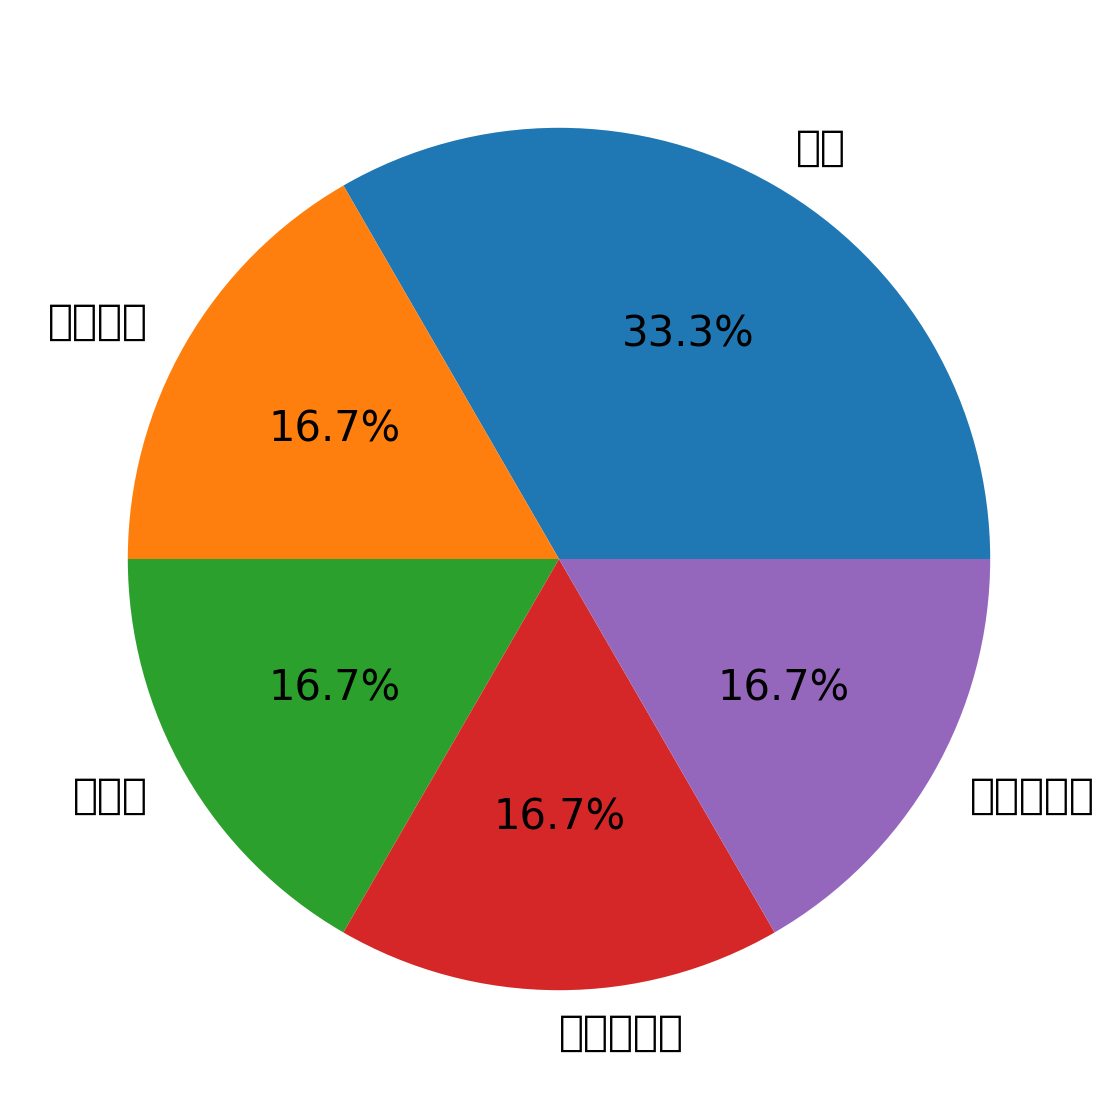

In [59]:
mpl.rc('font', size=15)
plt.figure(figsize=(7, 7))

# 타깃값 분포 파이 그래프
plt.pie(pd.Series(y).value_counts(), labels=pd.Series(y).value_counts().index, autopct='%.1f%%');

### 이미지 출력

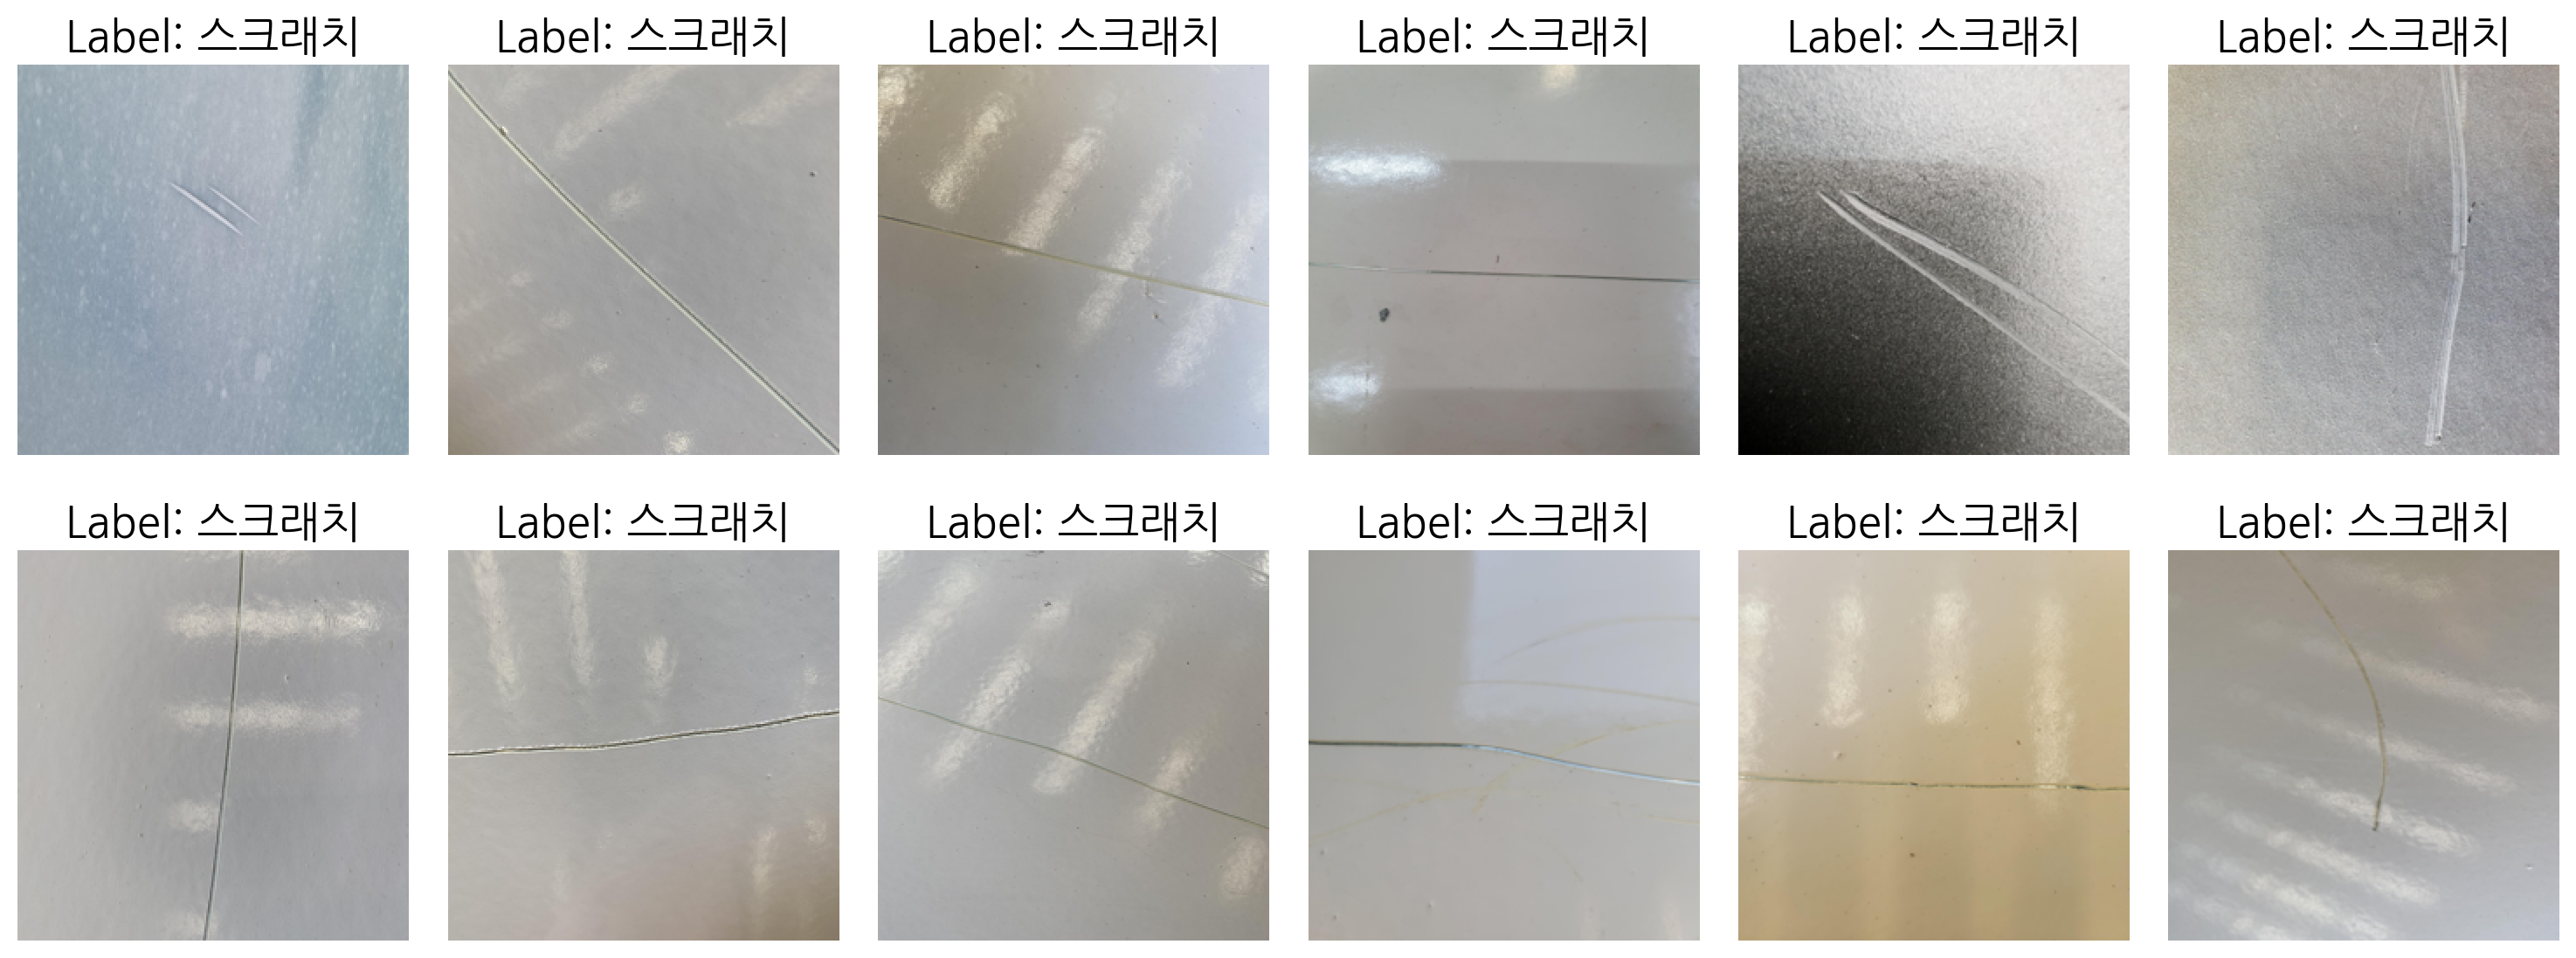

In [14]:
import matplotlib.gridspec as gridspec

# 이미지 및 라벨 확인
plt.rcParams['font.size'] = 15
plt.figure(figsize=(15, 6))  # 전체 Figure 크기 설정
grid = gridspec.GridSpec(2, 6) # 2행 6열로 서브플롯 배치

# 12개의 이미지 출력 (X와 y의 길이가 12라고 가정)
for idx, (image_data, label) in enumerate(zip(X[:12], y[:12])):
    ax = plt.subplot(grid[idx])
    ax.imshow(image_data)
    ax.set_title(f'Label: {label}')
    ax.axis('off')  # 축 정보 숨기기

plt.tight_layout() # 서브플롯 간의 간격 조정
plt.show()

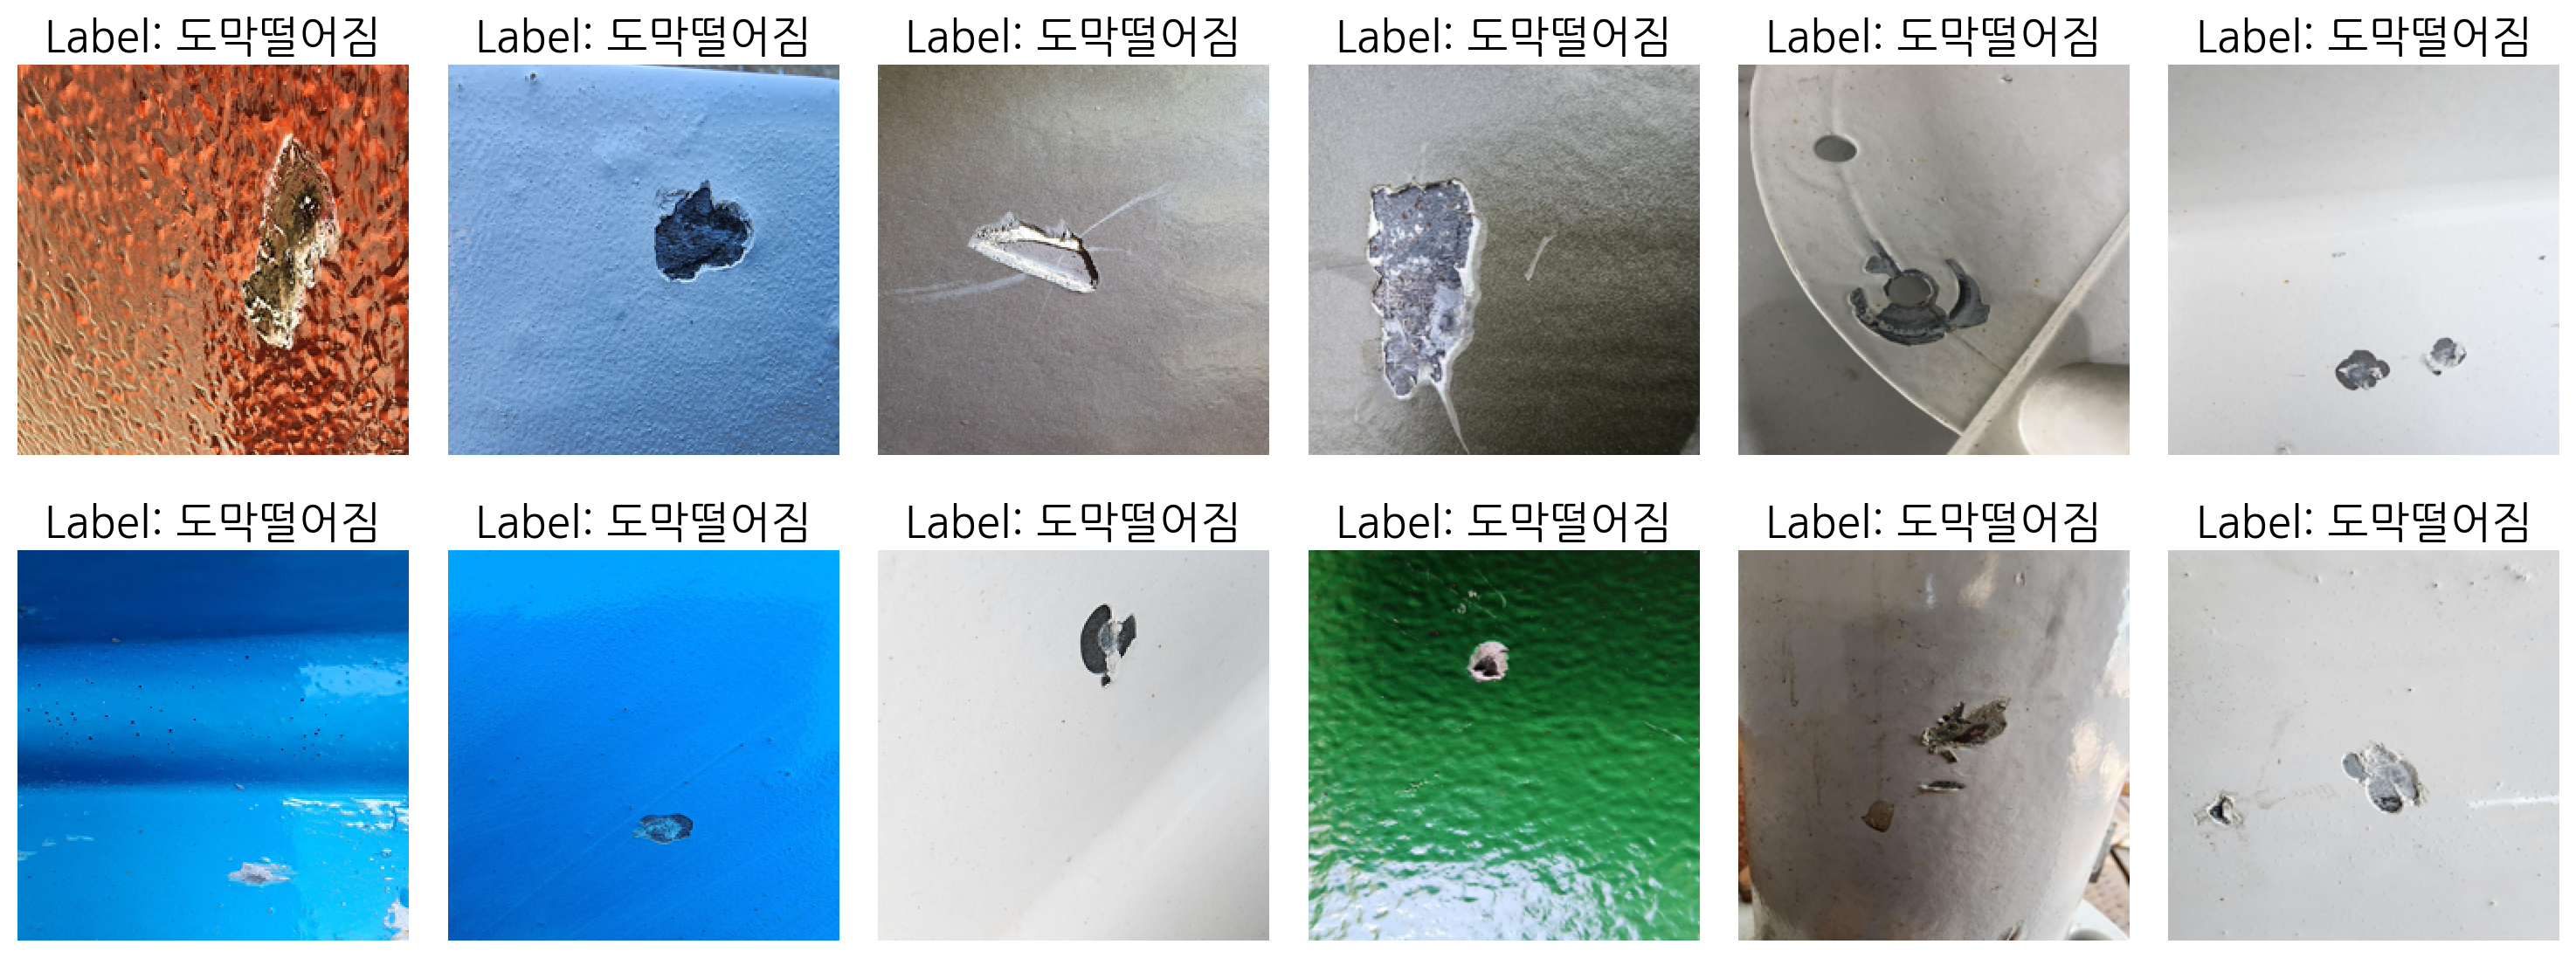

In [15]:
# 이미지 및 라벨 확인
plt.rcParams['font.size'] = 15
plt.figure(figsize=(15, 6))  # 전체 Figure 크기 설정
grid = gridspec.GridSpec(2, 6) # 2행 6열로 서브플롯 배치

# 12개의 이미지 출력 (X와 y의 길이가 12라고 가정)
for idx, (image_data, label) in enumerate(zip(X[500:512], y[500:512])):
    ax = plt.subplot(grid[idx])
    ax.imshow(image_data)
    ax.set_title(f'Label: {label}')
    ax.axis('off')  # 축 정보 숨기기

plt.tight_layout() # 서브플롯 간의 간격 조정
plt.show()

### 훈련 데이터, 검증 데이터 분리

In [16]:
# X는 (128, 128) 넘파이 배열들의 리스트, y는 라벨들의 리스트입니다.
# 훈련 데이터, 검증 데이터 분리

train_X, valid_X, train_y, valid_y = train_test_split(X, y,
                                                      test_size=0.2,
                                                      stratify=y,
                                                      random_state=50)

In [17]:
print('훈련 데이터 개수:', len(train_X))
print('검증 데이터 개수:', len(valid_X))

훈련 데이터 개수: 960
검증 데이터 개수: 240


### 데이터셋 클래스 정의

In [18]:
from torch.utils.data import Dataset

# 파이토치 Dataset 클래스
class ImageDataset(Dataset):
    def __init__(self, X, y=None, transform=None):
        super().__init__()
        self.X = X
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        
        if self.y is not None:
            # 리스트에서 직접 이미지와 라벨 가져오기
            image = self.X[idx]
            label = self.y[idx]
            
            # transform이 있다면 변환 적용
            if self.transform is not None:
                image = self.transform(image)
            
            # PyTorch CNN 모델 학습을 위해 라벨을 숫자로 매핑 (예시)
            # 실제 라벨에 맞춰 매핑 코드를 작성해야 합니다.
            label_map = {'양품': 0, '스크래치': 1, '부풀음': 2, '도막떨어짐':3, '이물질포함':4}
            label_tensor = torch.tensor(label_map[label], dtype=torch.long)
            
            return image, label_tensor
        
        else:
            # 추론 과정에서 라벨이 없을 때 사용
            image = self.X[idx]

            # transform이 있다면 변환 적용
            if self.transform is not None:
                image = self.transform(image)
                
            return image

### 이미지 변환기 정의 - Data Augmentation

In [19]:
from torchvision import transforms # 이미지 변환을 위한 모듈

# 훈련 데이터용 변환기
transform_train = transforms.Compose([transforms.ToTensor(),
                                      transforms.Pad(IMG_SIZE[0], padding_mode='symmetric'), 
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomVerticalFlip(),
                                      transforms.RandomRotation(30),
#                                       transforms.Normalize(mean=[0.5], std=[0.5])
                                      transforms.Normalize((0.485, 0.456, 0.406),
                                                           (0.229, 0.224, 0.225))
                                     ])

# 검증 및 테스트 데이터용 변환기
transform_test= transforms.Compose([transforms.ToTensor(),
                                    transforms.Pad(IMG_SIZE[0], padding_mode='symmetric'),
#                                     transforms.Normalize(mean=[0.5], std=[0.5])
                                    transforms.Normalize((0.485, 0.456, 0.406),
                                                           (0.229, 0.224, 0.225))
                                   ])

### 데이터셋 및 데이터 로더 생성

In [20]:
# Dataset 객체 생성
dataset_train = ImageDataset(X=train_X, y=train_y, transform=transform_train)
dataset_valid = ImageDataset(X=valid_X, y=valid_y, transform=transform_test)

In [21]:
# 데이터로드 시 병렬 처리를 위한 시드 설정
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)
    
g = torch.Generator()
g.manual_seed(0)

In [22]:
from torch.utils.data import DataLoader # 데이터 로더 클래스

batch_size = 16

loader_train = DataLoader(dataset=dataset_train, batch_size=batch_size, shuffle=True, worker_init_fn=seed_worker,
                          generator=g, num_workers=2)
loader_valid = DataLoader(dataset=dataset_valid, batch_size=batch_size, shuffle=False, worker_init_fn=seed_worker,
                          generator=g, num_workers=2)

## 모델 생성

In [23]:
# 모델 하이퍼파라미터
in_channels = 3
# save_file = "model_state_dict.pth"
img_size = tuple(x * 3 for x in IMG_SIZE)
img_size

(672, 672)

In [27]:
import torch.nn as nn
import torch.nn.functional as F
import torch

class Model(nn.Module):
    # 신경망 계층 정의
    def __init__(self, in_channels=in_channels, img_size=img_size):
        super().__init__()
        
        # 1 ~ 5번째 {합성곱, 배치 정규화, 최대 풀링} 계층 
        self.layer1 = nn.Sequential(nn.Conv2d(in_channels=in_channels, out_channels=32,
                                              kernel_size=3, padding=2),
                                    nn.BatchNorm2d(32),
                                    nn.LeakyReLU(),
                                    nn.MaxPool2d(kernel_size=2))

        self.layer2 = nn.Sequential(nn.Conv2d(in_channels=32, out_channels=64,
                                              kernel_size=3, padding=2),
                                    nn.BatchNorm2d(64),
                                    nn.LeakyReLU(),
                                    nn.MaxPool2d(kernel_size=2))
                                    
        self.layer3 = nn.Sequential(nn.Conv2d(in_channels=64, out_channels=128,
                                              kernel_size=3, padding=2),
                                    nn.BatchNorm2d(128),
                                    nn.LeakyReLU(),
                                    nn.MaxPool2d(kernel_size=2))
                                    
        self.layer4 = nn.Sequential(nn.Conv2d(in_channels=128, out_channels=256,
                                              kernel_size=3, padding=2),
                                    nn.BatchNorm2d(256),
                                    nn.LeakyReLU(),
                                    nn.MaxPool2d(kernel_size=2))
                                    
        self.layer5 = nn.Sequential(nn.Conv2d(in_channels=256, out_channels=512,
                                              kernel_size=3, padding=2),
                                    nn.BatchNorm2d(512),
                                    nn.LeakyReLU(),
                                    nn.MaxPool2d(kernel_size=2))
        
        # 평균 풀링 계층 
        self.avg_pool = nn.AvgPool2d(kernel_size=4)
#         self.avg_pool = nn.AdaptiveAvgPool2d((1, 1)) # (1, 1)은 최종 출력 크기를 의미

#         ----------------- fc 레이어 input shape 자동계산 코드 -----------------
#         더미 데이터를 만들어 모델의 전처리 레이어를 통과시킵니다.
#         이렇게 하면 최종적으로 flatten해야 할 피처맵의 크기를 알 수 있습니다.
        with torch.no_grad(): # 기울기 계산을 비활성화하여 메모리 낭비를 막음
            dummy_input = torch.zeros(1, in_channels, img_size[0], img_size[1])
            x = self.layer1(dummy_input)
            x = self.layer2(x)
            x = self.layer3(x)
            x = self.layer4(x)
            x = self.layer5(x)
            x = self.avg_pool(x)
            
            # x.view(x.size(0), -1)를 통해 평탄화된 피처의 개수를 가져옵니다.
            # x.size(0)은 배치 크기이므로 -1을 사용해 자동 계산합니다.
            self.in_shape = x.view(x.size(0), -1).size(1)
            
        # 전결합 계층에 계산된 크기를 적용
        self.fc1 = nn.Linear(in_features=self.in_shape, out_features=64)
#         self.fc1 = nn.Linear(in_features=512, out_features=64) # AdaptiveAvgPool2d 사용하는 경우
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(in_features=64, out_features=5)

    # 순전파 출력 정의 
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1) # 배치 차원은 유지하며 평탄화
        x = self.fc1(x)
        x = self.dropout(x) # 드롭아웃 적용
        x = self.fc2(x)
        return x

In [28]:
images, labels = next(iter(loader_train))
print("훈련 데이터 이미지 크기:", images.shape)

훈련 데이터 이미지 크기: torch.Size([16, 3, 672, 672])


In [29]:
model = Model().to(device)
model

Model(
  (layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer4): Sequential(
    (0): Conv2d(128,

## 모델 훈련

### 손실 함수와 옵티마이저 설정

In [30]:
# 손실 함수
criterion = nn.CrossEntropyLoss()

In [31]:
# 옵티마이저
# optimizer = torch.optim.Adamax(model.parameters(), lr=0.00006)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00006, weight_decay=0.0001)

### 스케줄러 설정

In [32]:
from transformers import get_cosine_schedule_with_warmup

epochs = 39 # 총 에폭

# 스케줄러 생성
scheduler = get_cosine_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=len(loader_train)*3, 
                                            num_training_steps=len(loader_train)*epochs)

### 모델 훈련

In [33]:
# # Validation Loss 기준 모델 학습
# def train(model, loader_train, loader_valid, criterion, optimizer, 
#           scheduler=None, epochs=10, save_file='model_state_dict.pth'):
    
#     valid_loss_min = np.inf # 최소 손실값 초기화 (검증 데이터용) 

#     # 총 에폭만큼 반복
#     for epoch in range(epochs):
#         print(f'에폭 [{epoch+1}/{epochs}] \n-----------------------------')
        
#         # == [ 훈련 ] ==============================================
#         model.train()        # 모델을 훈련 상태로 설정
#         epoch_train_loss = 0 # 에폭별 손실값 초기화 (훈련 데이터용)
#         # '반복 횟수'만큼 반복 
#         for images, labels in tqdm(loader_train):
#             # 이미지, 레이블(타깃값) 데이터 미니배치를 장비에 할당 
#             images = images.to(device)
#             labels = labels.to(device)
            
#             # 옵티마이저 내 기울기 초기화
#             optimizer.zero_grad()
#             # 순전파 : 이미지 데이터를 신경망 모델의 입력값으로 사용해 출력값 계산
#             outputs = model(images)
#             # 손실 함수를 활용해 outputs와 labels의 손실값 계산
#             loss = criterion(outputs, labels)
#             # 현재 배치에서의 손실 추가 (훈련 데이터용)
#             epoch_train_loss += loss.item() 
#             loss.backward()       # 역전파 수행
#             optimizer.step()      # 가중치 갱신
#             if scheduler != None: # 스케줄러 학습률 갱신 
#                 scheduler.step() 

#         # 훈련 데이터 손실값 출력
#         print(f'\t훈련 데이터 손실값 : {epoch_train_loss/len(loader_train):.4f}')
        
#         # == [ 검증 ] ==============================================
#         model.eval()         # 모델을 평가 상태로 설정 
#         epoch_valid_loss = 0 # 에폭별 손실값 초기화 (검증 데이터용)
#         preds_list = []      # 예측값 저장용 리스트 초기화
#         true_list = []       # 실젯값 저장용 리스트 초기화
        
#         with torch.no_grad(): # 기울기 계산 비활성화
#             for images, labels in loader_valid:
#                 images = images.to(device)
#                 labels = labels.to(device)
                
#                 outputs = model(images)
#                 loss = criterion(outputs, labels)
#                 epoch_valid_loss += loss.item()
                
#                 # 예측값 및 실제값 
#                 preds = torch.argmax(outputs.cpu(), dim=1).numpy() 
#                 true = labels.cpu().numpy() 
    
#                 preds_list.extend(preds)
#                 true_list.extend(true)
                
#         # 정확도, 정밀도, 재현율, F1 점수 계산
#         val_accuracy = accuracy_score(true_list, preds_list)
#         val_precision = precision_score(true_list, preds_list, average='macro')
#         val_recall = recall_score(true_list, preds_list, average='macro')
#         val_f1_score = f1_score(true_list, preds_list, average='macro')

#         # 검증 데이터 손실값 및 정확도, 재현율, F1점수 출력
#         print(f'\t검증 데이터 손실값 : {epoch_valid_loss/len(loader_valid):.4f}')
#         print(f'\t정확도 : {val_accuracy:.4f} / 정밀도 : {val_precision:.4f} / 재현율 : {val_recall:.4f} / F1 점수 : {val_f1_score:.4f}')
#         # == [ 최적 모델 가중치 찾기 ] ==============================
#         # 현 에폭에서의 손실값이 최소 손실값 이하면 모델 가중치 저장 
#         if epoch_valid_loss <= valid_loss_min: 
#             print(f'\t### 검증 데이터 손실값 감소 ({valid_loss_min/len(loader_valid):.4f} --> {epoch_valid_loss/len(loader_valid):.4f}). 모델 저장')
#             # 모델 가중치를 파일로 저장 
#             torch.save(model.state_dict(), save_file) 
#             valid_loss_min = epoch_valid_loss/len(loader_valid) # 최소 손실값 갱신 
#     return torch.load(save_file) # 저장한 모델 가중치를 불러와 반환

In [34]:
# ## Validation F1 Score 기준 모델 학습
# def train(model, loader_train, loader_valid, criterion, optimizer,
#           scheduler=None, epochs=10, save_file='model_state_dict.pth'):
    
#     valid_f1_score_max = 0.0

#     for epoch in range(epochs):
#         print(f'에폭 [{epoch+1}/{epochs}] \n-----------------------------')
        
#         # == [ 훈련 ] ==============================================
#         model.train()
#         epoch_train_loss = 0
#         train_preds_list = []
#         train_true_list = []
        
#         for images, labels in tqdm(loader_train):
#             images = images.to(device)
#             labels = labels.to(device)
            
#             optimizer.zero_grad()
#             outputs = model(images)
#             loss = criterion(outputs, labels)
#             epoch_train_loss += loss.item()
#             loss.backward()
#             optimizer.step()
            
#             if scheduler != None:
#                 scheduler.step()

#             # 훈련 데이터 예측값 및 실제값
#             train_preds = torch.argmax(outputs.cpu(), dim=1).numpy()
#             train_true = labels.cpu().numpy()
#             train_preds_list.extend(train_preds)
#             train_true_list.extend(train_true)

#         # 훈련 데이터 지표 계산 및 출력
#         train_accuracy = accuracy_score(train_true_list, train_preds_list)
#         train_precision = precision_score(train_true_list, train_preds_list, average='macro', zero_division=0)
#         train_recall = recall_score(train_true_list, train_preds_list, average='macro', zero_division=0)
#         train_f1_score = f1_score(train_true_list, train_preds_list, average='macro', zero_division=0)

#         print(f'\t훈련 데이터 손실값 : {epoch_train_loss/len(loader_train):.4f}')
#         print(f'\t정확도 : {train_accuracy:.4f} / 정밀도 : {train_precision:.4f} / 재현율 : {train_recall:.4f} / F1 점수 : {train_f1_score:.4f}')

#         # == [ 검증 ] ==============================================
#         model.eval()
#         epoch_valid_loss = 0
#         valid_preds_list = []
#         valid_true_list = []
        
#         with torch.no_grad():
#             for images, labels in loader_valid:
#                 images = images.to(device)
#                 labels = labels.to(device)
                
#                 outputs = model(images)
#                 loss = criterion(outputs, labels)
#                 epoch_valid_loss += loss.item()
                
#                 valid_preds = torch.argmax(outputs.cpu(), dim=1).numpy()
#                 valid_true = labels.cpu().numpy()
        
#                 valid_preds_list.extend(valid_preds)
#                 valid_true_list.extend(valid_true)
                
#         # 검증 데이터 지표 계산 및 출력
#         val_accuracy = accuracy_score(valid_true_list, valid_preds_list)
#         val_precision = precision_score(valid_true_list, valid_preds_list, average='macro', zero_division=0)
#         val_recall = recall_score(valid_true_list, valid_preds_list, average='macro', zero_division=0)
#         val_f1_score = f1_score(valid_true_list, valid_preds_list, average='macro', zero_division=0)

#         print(f'\t검증 데이터 손실값 : {epoch_valid_loss/len(loader_valid):.4f}')
#         print(f'\t정확도 : {val_accuracy:.4f} / 정밀도 : {val_precision:.4f} / 재현율 : {val_recall:.4f} / F1 점수 : {val_f1_score:.4f}')

#         # == [ 최적 모델 가중치 찾기 ] ==============================
#         if val_f1_score >= valid_f1_score_max:
#             print(f'\t### 검증 F1 점수 증가 ({valid_f1_score_max:.4f} --> {val_f1_score:.4f}). 모델 저장')
#             torch.save(model.state_dict(), save_file)
#             valid_f1_score_max = val_f1_score

#     return torch.load(save_file)

In [35]:
## Validation F1 Score 기준 모델 학습 + history 기록
def train(model, loader_train, loader_valid, criterion, optimizer,
          scheduler=None, epochs=10, save_file='model_state_dict.pth'):
    
    valid_f1_score_max = 0.0
    history = {
        'train_loss': [], 'train_accuracy': [], 'train_precision': [], 'train_recall': [], 'train_f1_score': [],
        'valid_loss': [], 'valid_accuracy': [], 'valid_precision': [], 'valid_recall': [], 'valid_f1_score': []
    }

    for epoch in range(epochs):
        print(f'에폭 [{epoch+1}/{epochs}] \n-----------------------------')
        
        # == [ 훈련 ] ==============================================
        model.train()
        epoch_train_loss = 0
        train_preds_list = []
        train_true_list = []
        
        for images, labels in tqdm(loader_train):
            images = images.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            epoch_train_loss += loss.item()
            loss.backward()
            optimizer.step()
            
            if scheduler != None:
                scheduler.step()

            # 훈련 데이터 예측값 및 실제값
            train_preds = torch.argmax(outputs.cpu(), dim=1).numpy()
            train_true = labels.cpu().numpy()
            train_preds_list.extend(train_preds)
            train_true_list.extend(train_true)

        # 훈련 데이터 지표 계산 및 출력
        train_loss = epoch_train_loss / len(loader_train)
        train_accuracy = accuracy_score(train_true_list, train_preds_list)
        train_precision = precision_score(train_true_list, train_preds_list, average='macro', zero_division=0)
        train_recall = recall_score(train_true_list, train_preds_list, average='macro', zero_division=0)
        train_f1_score = f1_score(train_true_list, train_preds_list, average='macro', zero_division=0)

        history['train_loss'].append(train_loss)
        history['train_accuracy'].append(train_accuracy)
        history['train_precision'].append(train_precision)
        history['train_recall'].append(train_recall)
        history['train_f1_score'].append(train_f1_score)

        print(f'\t훈련 데이터 손실값 : {train_loss:.4f}')
        print(f'\t정확도 : {train_accuracy:.4f} / 정밀도 : {train_precision:.4f} / 재현율 : {train_recall:.4f} / F1 점수 : {train_f1_score:.4f}')

        # == [ 검증 ] ==============================================
        model.eval()
        epoch_valid_loss = 0
        valid_preds_list = []
        valid_true_list = []
        
        with torch.no_grad():
            for images, labels in loader_valid:
                images = images.to(device)
                labels = labels.to(device)
                
                outputs = model(images)
                loss = criterion(outputs, labels)
                epoch_valid_loss += loss.item()
                
                valid_preds = torch.argmax(outputs.cpu(), dim=1).numpy()
                valid_true = labels.cpu().numpy()
        
                valid_preds_list.extend(valid_preds)
                valid_true_list.extend(valid_true)
                
        # 검증 데이터 지표 계산 및 출력
        valid_loss = epoch_valid_loss / len(loader_valid)
        val_accuracy = accuracy_score(valid_true_list, valid_preds_list)
        val_precision = precision_score(valid_true_list, valid_preds_list, average='macro', zero_division=0)
        val_recall = recall_score(valid_true_list, valid_preds_list, average='macro', zero_division=0)
        val_f1_score = f1_score(valid_true_list, valid_preds_list, average='macro', zero_division=0)

        history['valid_loss'].append(valid_loss)
        history['valid_accuracy'].append(val_accuracy)
        history['valid_precision'].append(val_precision)
        history['valid_recall'].append(val_recall)
        history['valid_f1_score'].append(val_f1_score)

        print(f'\t검증 데이터 손실값 : {valid_loss:.4f}')
        print(f'\t정확도 : {val_accuracy:.4f} / 정밀도 : {val_precision:.4f} / 재현율 : {val_recall:.4f} / F1 점수 : {val_f1_score:.4f}')

        # == [ 최적 모델 가중치 찾기 ] ==============================
        if val_f1_score >= valid_f1_score_max:
            print(f'\t### 검증 F1 점수 증가 ({valid_f1_score_max:.4f} --> {val_f1_score:.4f}). 모델 저장')
            torch.save(model.state_dict(), save_file)
            valid_f1_score_max = val_f1_score

    # 모델 가중치와 훈련 이력을 반환
    return torch.load(save_file), history

In [36]:
# 모델 훈련
model_state_dict, history = train(model=model,
                         loader_train=loader_train, 
                         loader_valid=loader_valid,
                         criterion=criterion, 
                         optimizer=optimizer,
                         scheduler=scheduler,
                         epochs=epochs)

# 모델에 최적 가중치 적용
model.load_state_dict(model_state_dict)

에폭 [1/39] 
-----------------------------


  0%|          | 0/60 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 1.4619
	정확도 : 0.4052 / 정밀도 : 0.3711 / 재현율 : 0.3513 / F1 점수 : 0.3494
	검증 데이터 손실값 : 1.2355
	정확도 : 0.4792 / 정밀도 : 0.4743 / 재현율 : 0.4275 / F1 점수 : 0.3891
	### 검증 F1 점수 증가 (0.0000 --> 0.3891). 모델 저장
에폭 [2/39] 
-----------------------------


  0%|          | 0/60 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.9695
	정확도 : 0.6406 / 정밀도 : 0.6126 / 재현율 : 0.5900 / F1 점수 : 0.5905
	검증 데이터 손실값 : 0.8721
	정확도 : 0.7167 / 정밀도 : 0.7374 / 재현율 : 0.6875 / F1 점수 : 0.6785
	### 검증 F1 점수 증가 (0.3891 --> 0.6785). 모델 저장
에폭 [3/39] 
-----------------------------


  0%|          | 0/60 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.7142
	정확도 : 0.7667 / 정밀도 : 0.7533 / 재현율 : 0.7388 / F1 점수 : 0.7447
	검증 데이터 손실값 : 0.5892
	정확도 : 0.8417 / 정밀도 : 0.8456 / 재현율 : 0.8175 / F1 점수 : 0.8248
	### 검증 F1 점수 증가 (0.6785 --> 0.8248). 모델 저장
에폭 [4/39] 
-----------------------------


  0%|          | 0/60 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.5364
	정확도 : 0.8104 / 정밀도 : 0.7969 / 재현율 : 0.7881 / F1 점수 : 0.7916
	검증 데이터 손실값 : 0.5827
	정확도 : 0.8708 / 정밀도 : 0.8661 / 재현율 : 0.8750 / F1 점수 : 0.8655
	### 검증 F1 점수 증가 (0.8248 --> 0.8655). 모델 저장
에폭 [5/39] 
-----------------------------


  0%|          | 0/60 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.4697
	정확도 : 0.8542 / 정밀도 : 0.8409 / 재현율 : 0.8331 / F1 점수 : 0.8367
	검증 데이터 손실값 : 0.3900
	정확도 : 0.8875 / 정밀도 : 0.8759 / 재현율 : 0.8850 / F1 점수 : 0.8800
	### 검증 F1 점수 증가 (0.8655 --> 0.8800). 모델 저장
에폭 [6/39] 
-----------------------------


  0%|          | 0/60 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.4470
	정확도 : 0.8448 / 정밀도 : 0.8319 / 재현율 : 0.8262 / F1 점수 : 0.8284
	검증 데이터 손실값 : 0.3961
	정확도 : 0.8792 / 정밀도 : 0.8824 / 재현율 : 0.8650 / F1 점수 : 0.8619
에폭 [7/39] 
-----------------------------


  0%|          | 0/60 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.3840
	정확도 : 0.8635 / 정밀도 : 0.8522 / 재현율 : 0.8456 / F1 점수 : 0.8487
	검증 데이터 손실값 : 0.3405
	정확도 : 0.9042 / 정밀도 : 0.9010 / 재현율 : 0.9025 / F1 점수 : 0.8980
	### 검증 F1 점수 증가 (0.8800 --> 0.8980). 모델 저장
에폭 [8/39] 
-----------------------------


  0%|          | 0/60 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.3478
	정확도 : 0.8719 / 정밀도 : 0.8599 / 재현율 : 0.8544 / F1 점수 : 0.8569
	검증 데이터 손실값 : 0.2867
	정확도 : 0.8958 / 정밀도 : 0.8905 / 재현율 : 0.8900 / F1 점수 : 0.8873
에폭 [9/39] 
-----------------------------


  0%|          | 0/60 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.2982
	정확도 : 0.9021 / 정밀도 : 0.8905 / 재현율 : 0.8844 / F1 점수 : 0.8873
	검증 데이터 손실값 : 0.2657
	정확도 : 0.9208 / 정밀도 : 0.9221 / 재현율 : 0.9100 / F1 점수 : 0.9101
	### 검증 F1 점수 증가 (0.8980 --> 0.9101). 모델 저장
에폭 [10/39] 
-----------------------------


  0%|          | 0/60 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.2724
	정확도 : 0.9000 / 정밀도 : 0.8895 / 재현율 : 0.8862 / F1 점수 : 0.8878
	검증 데이터 손실값 : 0.4059
	정확도 : 0.9042 / 정밀도 : 0.9146 / 재현율 : 0.8900 / F1 점수 : 0.8914
에폭 [11/39] 
-----------------------------


  0%|          | 0/60 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.3288
	정확도 : 0.9010 / 정밀도 : 0.8922 / 재현율 : 0.8888 / F1 점수 : 0.8904
	검증 데이터 손실값 : 0.2907
	정확도 : 0.9083 / 정밀도 : 0.9191 / 재현율 : 0.9075 / F1 점수 : 0.9026
에폭 [12/39] 
-----------------------------


  0%|          | 0/60 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.2957
	정확도 : 0.8969 / 정밀도 : 0.8861 / 재현율 : 0.8787 / F1 점수 : 0.8821
	검증 데이터 손실값 : 0.2479
	정확도 : 0.9167 / 정밀도 : 0.9256 / 재현율 : 0.9100 / F1 점수 : 0.9115
	### 검증 F1 점수 증가 (0.9101 --> 0.9115). 모델 저장
에폭 [13/39] 
-----------------------------


  0%|          | 0/60 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.2150
	정확도 : 0.9292 / 정밀도 : 0.9192 / 재현율 : 0.9187 / F1 점수 : 0.9190
	검증 데이터 손실값 : 0.2595
	정확도 : 0.9292 / 정밀도 : 0.9286 / 재현율 : 0.9225 / F1 점수 : 0.9244
	### 검증 F1 점수 증가 (0.9115 --> 0.9244). 모델 저장
에폭 [14/39] 
-----------------------------


  0%|          | 0/60 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.2544
	정확도 : 0.9146 / 정밀도 : 0.9044 / 재현율 : 0.9012 / F1 점수 : 0.9025
	검증 데이터 손실값 : 0.1913
	정확도 : 0.9417 / 정밀도 : 0.9428 / 재현율 : 0.9350 / F1 점수 : 0.9378
	### 검증 F1 점수 증가 (0.9244 --> 0.9378). 모델 저장
에폭 [15/39] 
-----------------------------


  0%|          | 0/60 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.2295
	정확도 : 0.9271 / 정밀도 : 0.9200 / 재현율 : 0.9156 / F1 점수 : 0.9175
	검증 데이터 손실값 : 0.1884
	정확도 : 0.9500 / 정밀도 : 0.9443 / 재현율 : 0.9500 / F1 점수 : 0.9468
	### 검증 F1 점수 증가 (0.9378 --> 0.9468). 모델 저장
에폭 [16/39] 
-----------------------------


  0%|          | 0/60 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.2529
	정확도 : 0.9208 / 정밀도 : 0.9156 / 재현율 : 0.9081 / F1 점수 : 0.9116
	검증 데이터 손실값 : 0.2253
	정확도 : 0.9458 / 정밀도 : 0.9437 / 재현율 : 0.9400 / F1 점수 : 0.9381
에폭 [17/39] 
-----------------------------


  0%|          | 0/60 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.1979
	정확도 : 0.9292 / 정밀도 : 0.9212 / 재현율 : 0.9181 / F1 점수 : 0.9196
	검증 데이터 손실값 : 0.2457
	정확도 : 0.9375 / 정밀도 : 0.9421 / 재현율 : 0.9300 / F1 점수 : 0.9326
에폭 [18/39] 
-----------------------------


  0%|          | 0/60 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.1871
	정확도 : 0.9385 / 정밀도 : 0.9318 / 재현율 : 0.9275 / F1 점수 : 0.9294
	검증 데이터 손실값 : 0.2149
	정확도 : 0.9542 / 정밀도 : 0.9516 / 재현율 : 0.9475 / F1 점수 : 0.9487
	### 검증 F1 점수 증가 (0.9468 --> 0.9487). 모델 저장
에폭 [19/39] 
-----------------------------


  0%|          | 0/60 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.1626
	정확도 : 0.9427 / 정밀도 : 0.9404 / 재현율 : 0.9331 / F1 점수 : 0.9365
	검증 데이터 손실값 : 0.1800
	정확도 : 0.9500 / 정밀도 : 0.9454 / 재현율 : 0.9475 / F1 점수 : 0.9452
에폭 [20/39] 
-----------------------------


  0%|          | 0/60 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.1817
	정확도 : 0.9458 / 정밀도 : 0.9412 / 재현율 : 0.9388 / F1 점수 : 0.9397
	검증 데이터 손실값 : 0.2346
	정확도 : 0.9417 / 정밀도 : 0.9419 / 재현율 : 0.9325 / F1 점수 : 0.9357
에폭 [21/39] 
-----------------------------


  0%|          | 0/60 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.1651
	정확도 : 0.9479 / 정밀도 : 0.9422 / 재현율 : 0.9387 / F1 점수 : 0.9404
	검증 데이터 손실값 : 0.2034
	정확도 : 0.9500 / 정밀도 : 0.9520 / 재현율 : 0.9425 / F1 점수 : 0.9451
에폭 [22/39] 
-----------------------------


  0%|          | 0/60 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.1711
	정확도 : 0.9375 / 정밀도 : 0.9336 / 재현율 : 0.9269 / F1 점수 : 0.9296
	검증 데이터 손실값 : 0.1912
	정확도 : 0.9542 / 정밀도 : 0.9527 / 재현율 : 0.9525 / F1 점수 : 0.9515
	### 검증 F1 점수 증가 (0.9487 --> 0.9515). 모델 저장
에폭 [23/39] 
-----------------------------


  0%|          | 0/60 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.1480
	정확도 : 0.9542 / 정밀도 : 0.9497 / 재현율 : 0.9469 / F1 점수 : 0.9483
	검증 데이터 손실값 : 0.2156
	정확도 : 0.9542 / 정밀도 : 0.9521 / 재현율 : 0.9525 / F1 점수 : 0.9513
에폭 [24/39] 
-----------------------------


  0%|          | 0/60 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.1431
	정확도 : 0.9479 / 정밀도 : 0.9437 / 재현율 : 0.9400 / F1 점수 : 0.9416
	검증 데이터 손실값 : 0.2269
	정확도 : 0.9500 / 정밀도 : 0.9482 / 재현율 : 0.9450 / F1 점수 : 0.9439
에폭 [25/39] 
-----------------------------


  0%|          | 0/60 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.1418
	정확도 : 0.9510 / 정밀도 : 0.9467 / 재현율 : 0.9438 / F1 점수 : 0.9451
	검증 데이터 손실값 : 0.1752
	정확도 : 0.9708 / 정밀도 : 0.9701 / 재현율 : 0.9675 / F1 점수 : 0.9687
	### 검증 F1 점수 증가 (0.9515 --> 0.9687). 모델 저장
에폭 [26/39] 
-----------------------------


  0%|          | 0/60 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.1215
	정확도 : 0.9573 / 정밀도 : 0.9537 / 재현율 : 0.9488 / F1 점수 : 0.9511
	검증 데이터 손실값 : 0.1787
	정확도 : 0.9708 / 정밀도 : 0.9685 / 재현율 : 0.9725 / F1 점수 : 0.9703
	### 검증 F1 점수 증가 (0.9687 --> 0.9703). 모델 저장
에폭 [27/39] 
-----------------------------


  0%|          | 0/60 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.1217
	정확도 : 0.9635 / 정밀도 : 0.9613 / 재현율 : 0.9569 / F1 점수 : 0.9590
	검증 데이터 손실값 : 0.1692
	정확도 : 0.9625 / 정밀도 : 0.9592 / 재현율 : 0.9625 / F1 점수 : 0.9605
에폭 [28/39] 
-----------------------------


  0%|          | 0/60 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.1211
	정확도 : 0.9604 / 정밀도 : 0.9564 / 재현율 : 0.9538 / F1 점수 : 0.9548
	검증 데이터 손실값 : 0.1845
	정확도 : 0.9792 / 정밀도 : 0.9775 / 재현율 : 0.9775 / F1 점수 : 0.9774
	### 검증 F1 점수 증가 (0.9703 --> 0.9774). 모델 저장
에폭 [29/39] 
-----------------------------


  0%|          | 0/60 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.1205
	정확도 : 0.9615 / 정밀도 : 0.9595 / 재현율 : 0.9550 / F1 점수 : 0.9572
	검증 데이터 손실값 : 0.1639
	정확도 : 0.9750 / 정밀도 : 0.9726 / 재현율 : 0.9750 / F1 점수 : 0.9737
에폭 [30/39] 
-----------------------------


  0%|          | 0/60 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0972
	정확도 : 0.9729 / 정밀도 : 0.9724 / 재현율 : 0.9675 / F1 점수 : 0.9698
	검증 데이터 손실값 : 0.1655
	정확도 : 0.9792 / 정밀도 : 0.9775 / 재현율 : 0.9775 / F1 점수 : 0.9774
	### 검증 F1 점수 증가 (0.9774 --> 0.9774). 모델 저장
에폭 [31/39] 
-----------------------------


  0%|          | 0/60 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0973
	정확도 : 0.9719 / 정밀도 : 0.9699 / 재현율 : 0.9669 / F1 점수 : 0.9683
	검증 데이터 손실값 : 0.1658
	정확도 : 0.9833 / 정밀도 : 0.9825 / 재현율 : 0.9825 / F1 점수 : 0.9825
	### 검증 F1 점수 증가 (0.9774 --> 0.9825). 모델 저장
에폭 [32/39] 
-----------------------------


  0%|          | 0/60 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0978
	정확도 : 0.9625 / 정밀도 : 0.9587 / 재현율 : 0.9575 / F1 점수 : 0.9580
	검증 데이터 손실값 : 0.1838
	정확도 : 0.9667 / 정밀도 : 0.9639 / 재현율 : 0.9650 / F1 점수 : 0.9638
에폭 [33/39] 
-----------------------------


  0%|          | 0/60 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0969
	정확도 : 0.9688 / 정밀도 : 0.9672 / 재현율 : 0.9631 / F1 점수 : 0.9650
	검증 데이터 손실값 : 0.1842
	정확도 : 0.9750 / 정밀도 : 0.9729 / 재현율 : 0.9750 / F1 점수 : 0.9738
에폭 [34/39] 
-----------------------------


  0%|          | 0/60 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0970
	정확도 : 0.9740 / 정밀도 : 0.9728 / 재현율 : 0.9694 / F1 점수 : 0.9710
	검증 데이터 손실값 : 0.1710
	정확도 : 0.9750 / 정밀도 : 0.9729 / 재현율 : 0.9750 / F1 점수 : 0.9738
에폭 [35/39] 
-----------------------------


  0%|          | 0/60 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.1056
	정확도 : 0.9708 / 정밀도 : 0.9693 / 재현율 : 0.9662 / F1 점수 : 0.9677
	검증 데이터 손실값 : 0.1735
	정확도 : 0.9750 / 정밀도 : 0.9729 / 재현율 : 0.9750 / F1 점수 : 0.9738
에폭 [36/39] 
-----------------------------


  0%|          | 0/60 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0946
	정확도 : 0.9729 / 정밀도 : 0.9712 / 재현율 : 0.9681 / F1 점수 : 0.9696
	검증 데이터 손실값 : 0.1721
	정확도 : 0.9708 / 정밀도 : 0.9684 / 재현율 : 0.9675 / F1 점수 : 0.9675
에폭 [37/39] 
-----------------------------


  0%|          | 0/60 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0927
	정확도 : 0.9677 / 정밀도 : 0.9653 / 재현율 : 0.9625 / F1 점수 : 0.9638
	검증 데이터 손실값 : 0.1741
	정확도 : 0.9708 / 정밀도 : 0.9682 / 재현율 : 0.9700 / F1 점수 : 0.9689
에폭 [38/39] 
-----------------------------


  0%|          | 0/60 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0883
	정확도 : 0.9688 / 정밀도 : 0.9660 / 재현율 : 0.9631 / F1 점수 : 0.9645
	검증 데이터 손실값 : 0.1724
	정확도 : 0.9708 / 정밀도 : 0.9682 / 재현율 : 0.9700 / F1 점수 : 0.9689
에폭 [39/39] 
-----------------------------


  0%|          | 0/60 [00:00<?, ?it/s]

	훈련 데이터 손실값 : 0.0874
	정확도 : 0.9698 / 정밀도 : 0.9688 / 재현율 : 0.9644 / F1 점수 : 0.9664
	검증 데이터 손실값 : 0.1750
	정확도 : 0.9750 / 정밀도 : 0.9729 / 재현율 : 0.9750 / F1 점수 : 0.9738


<All keys matched successfully>

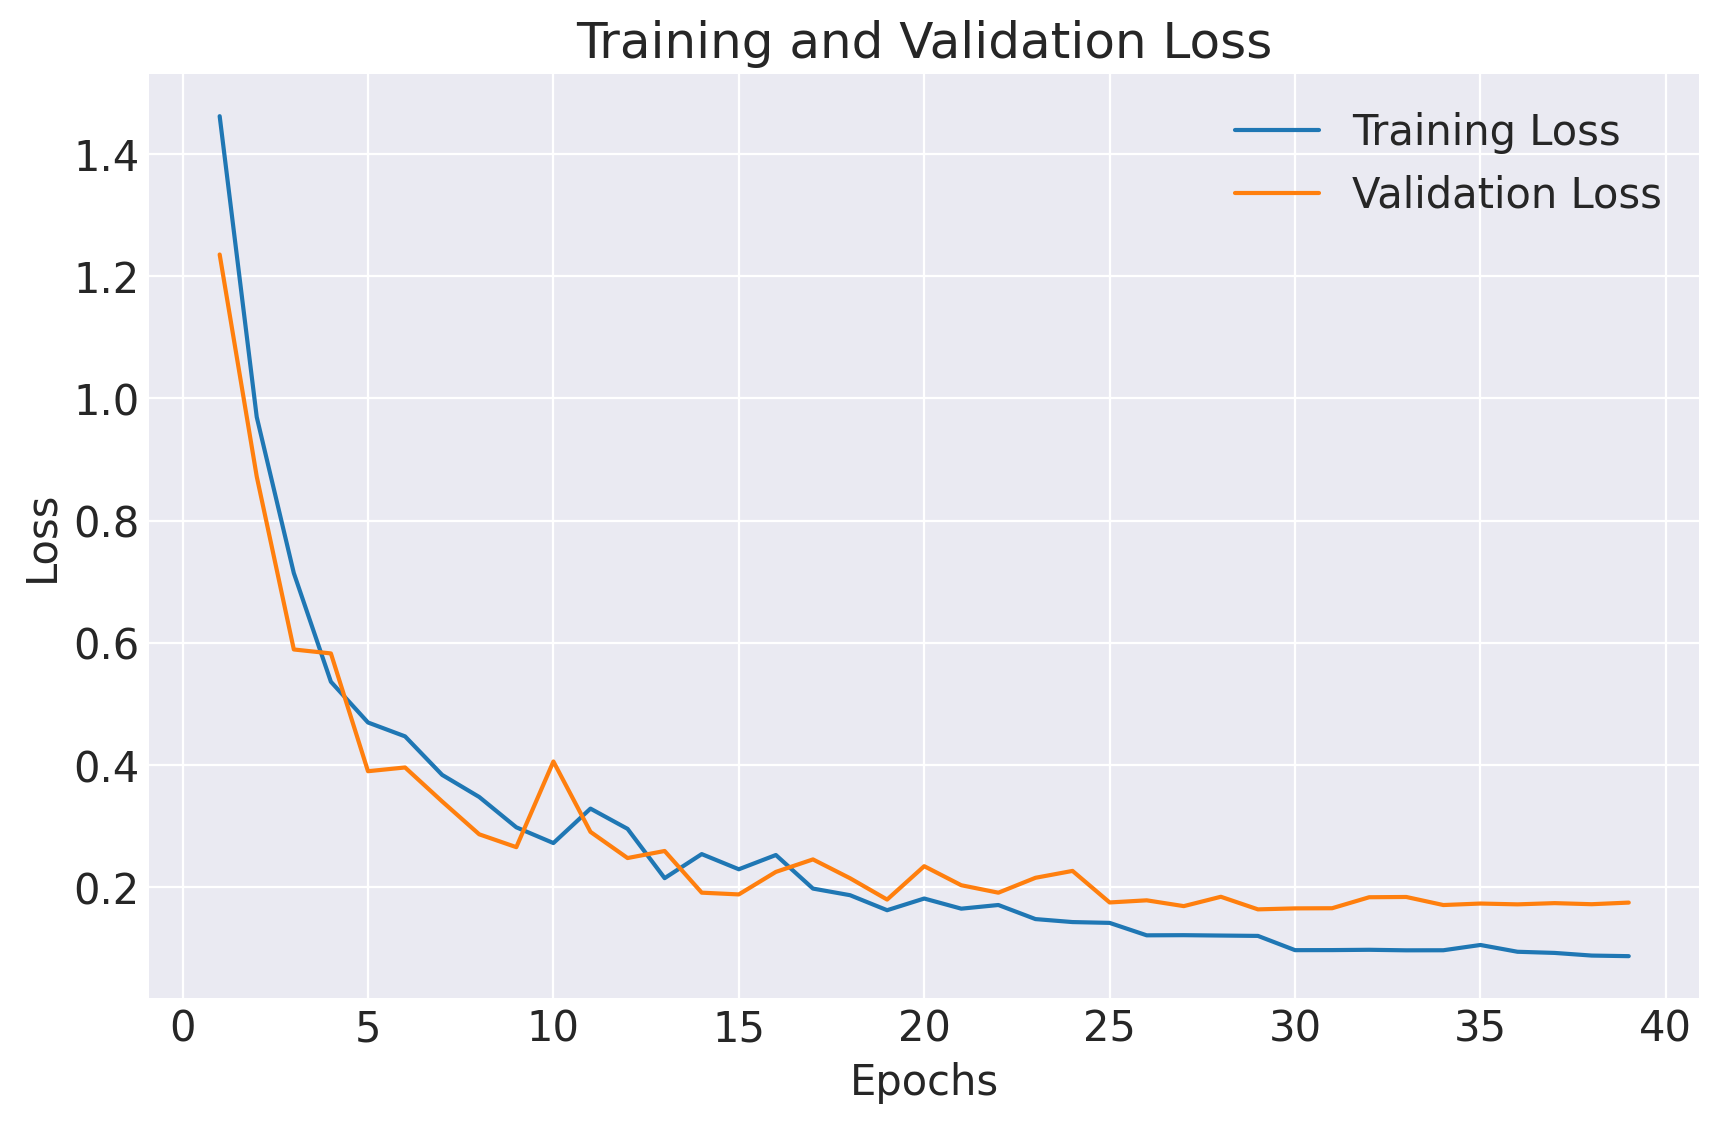

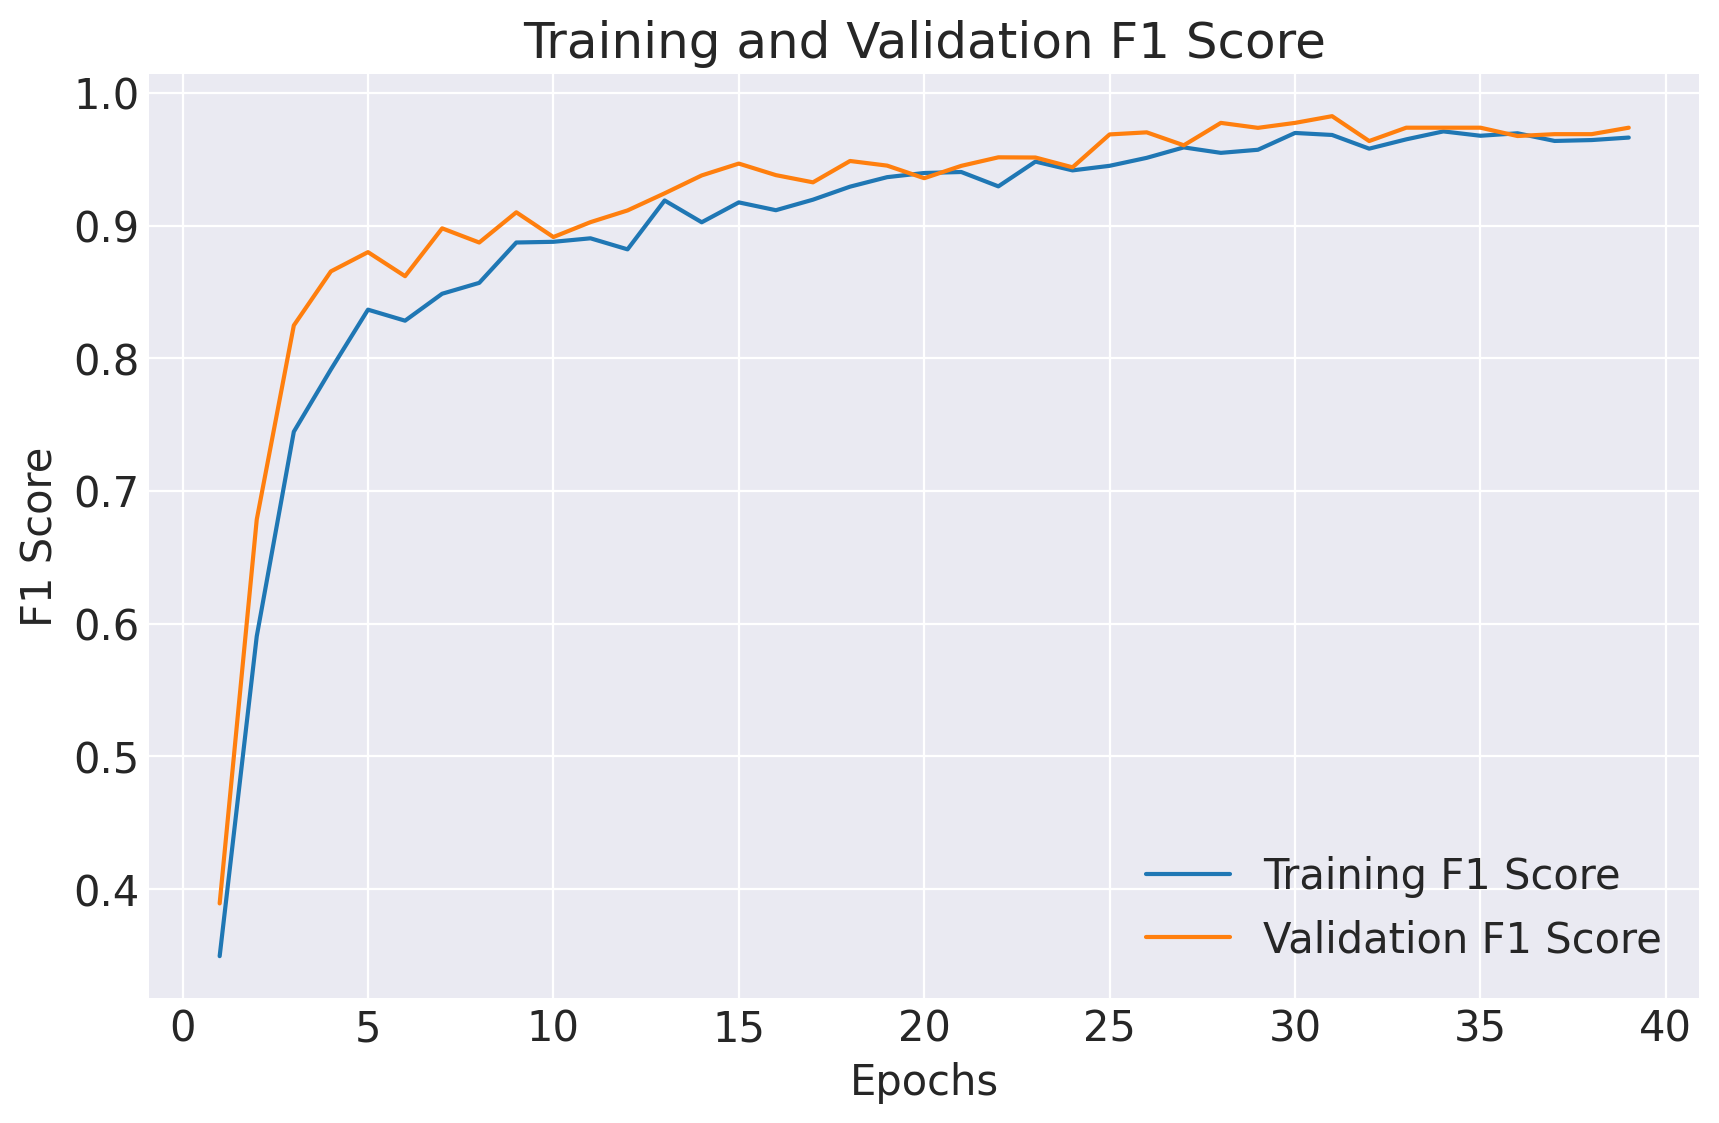

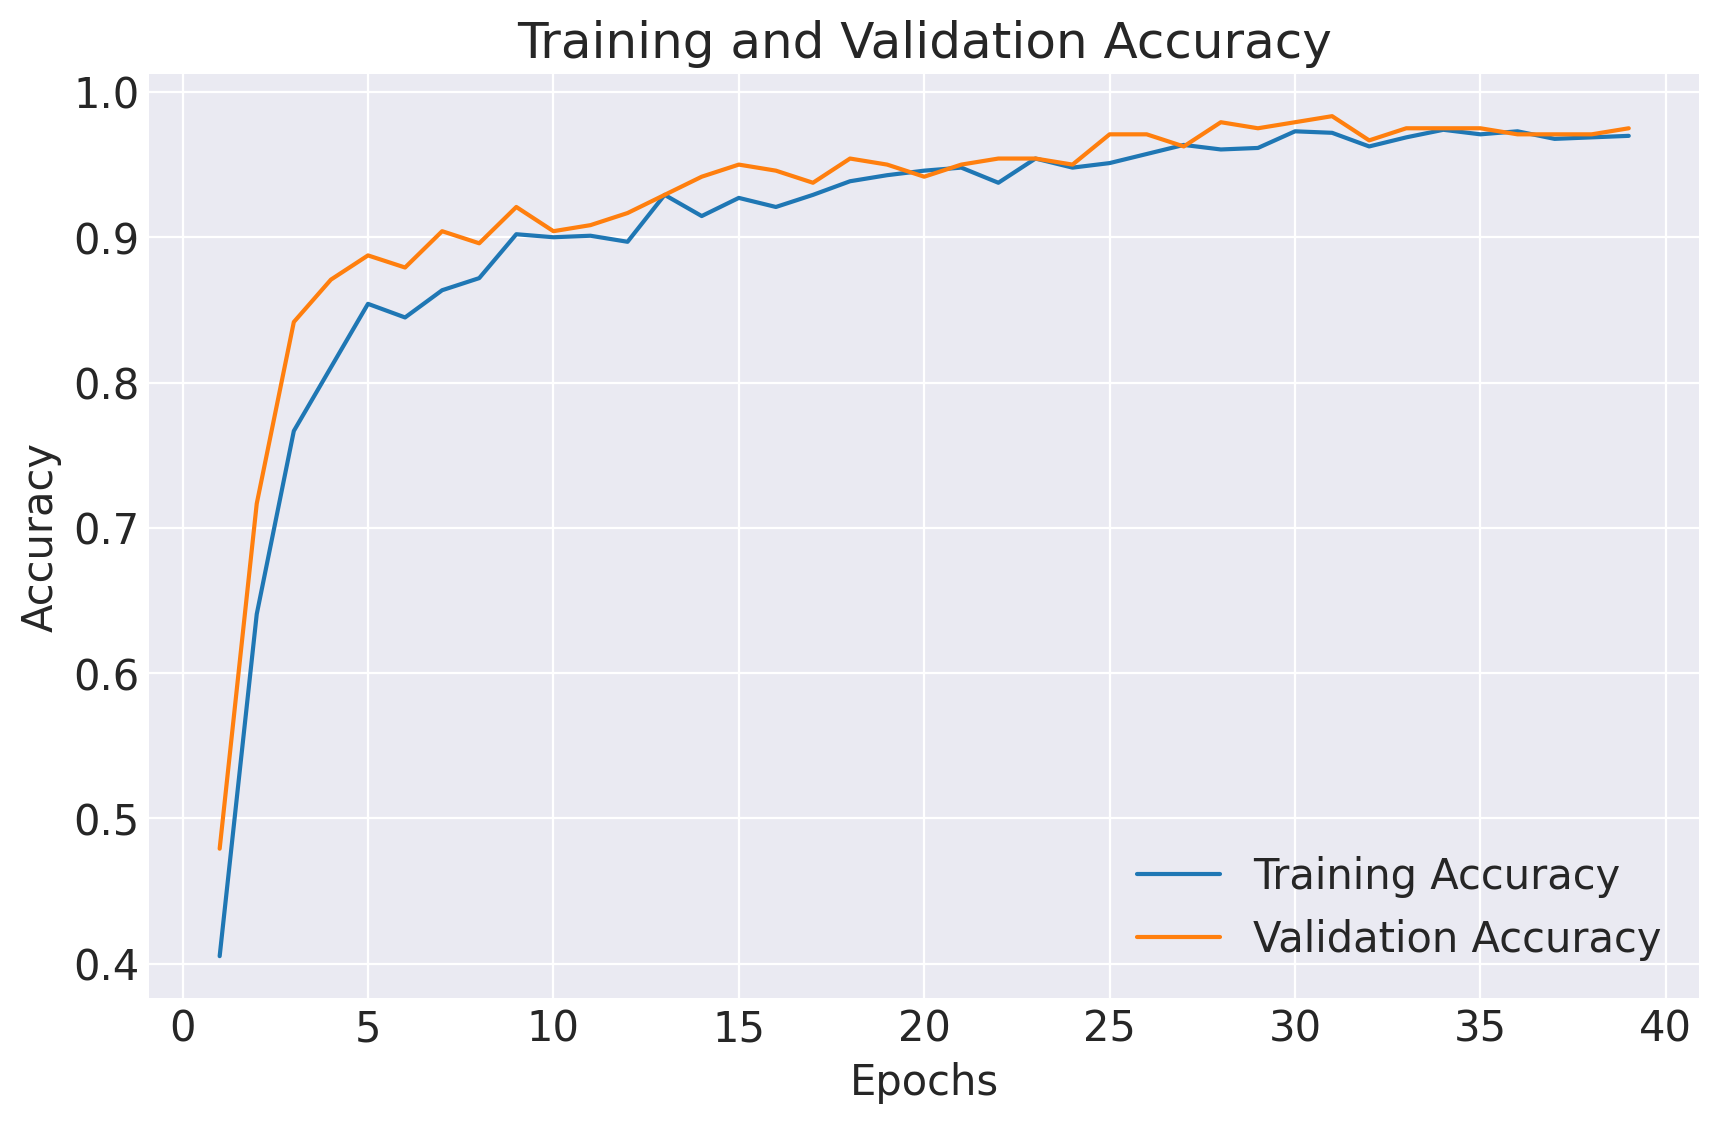

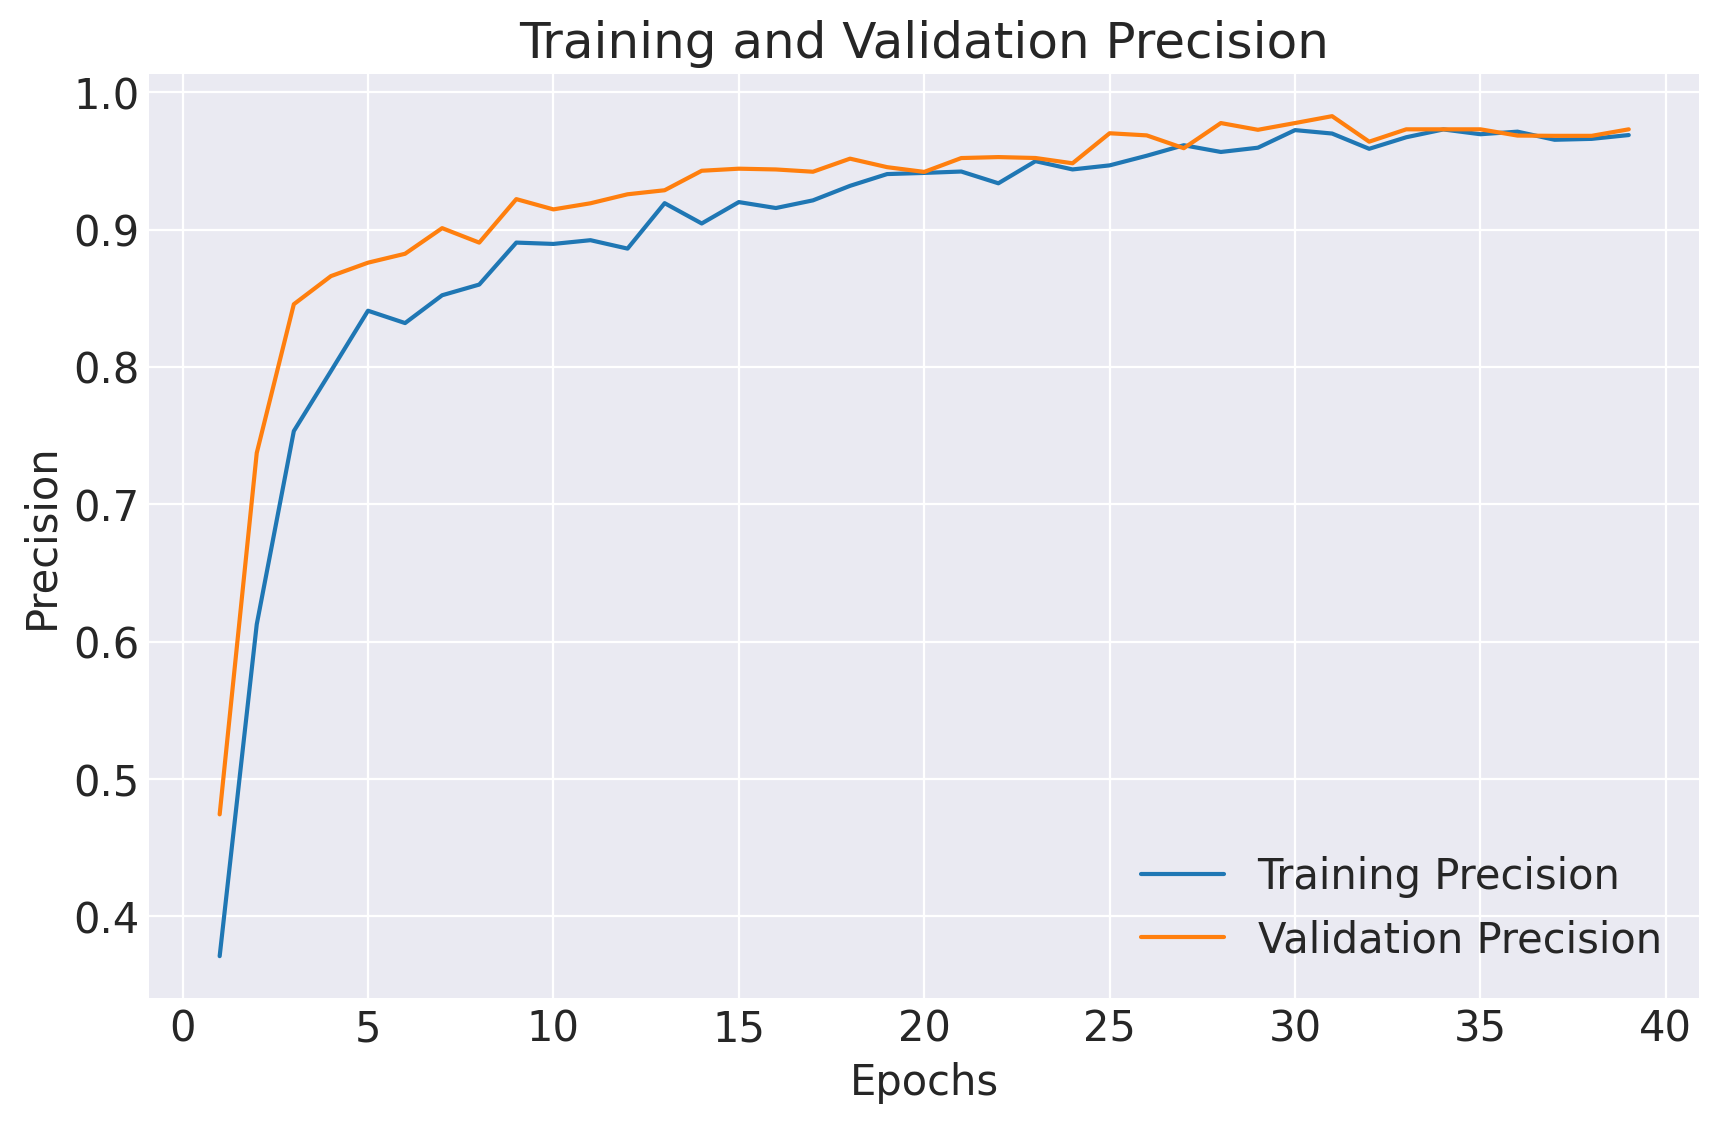

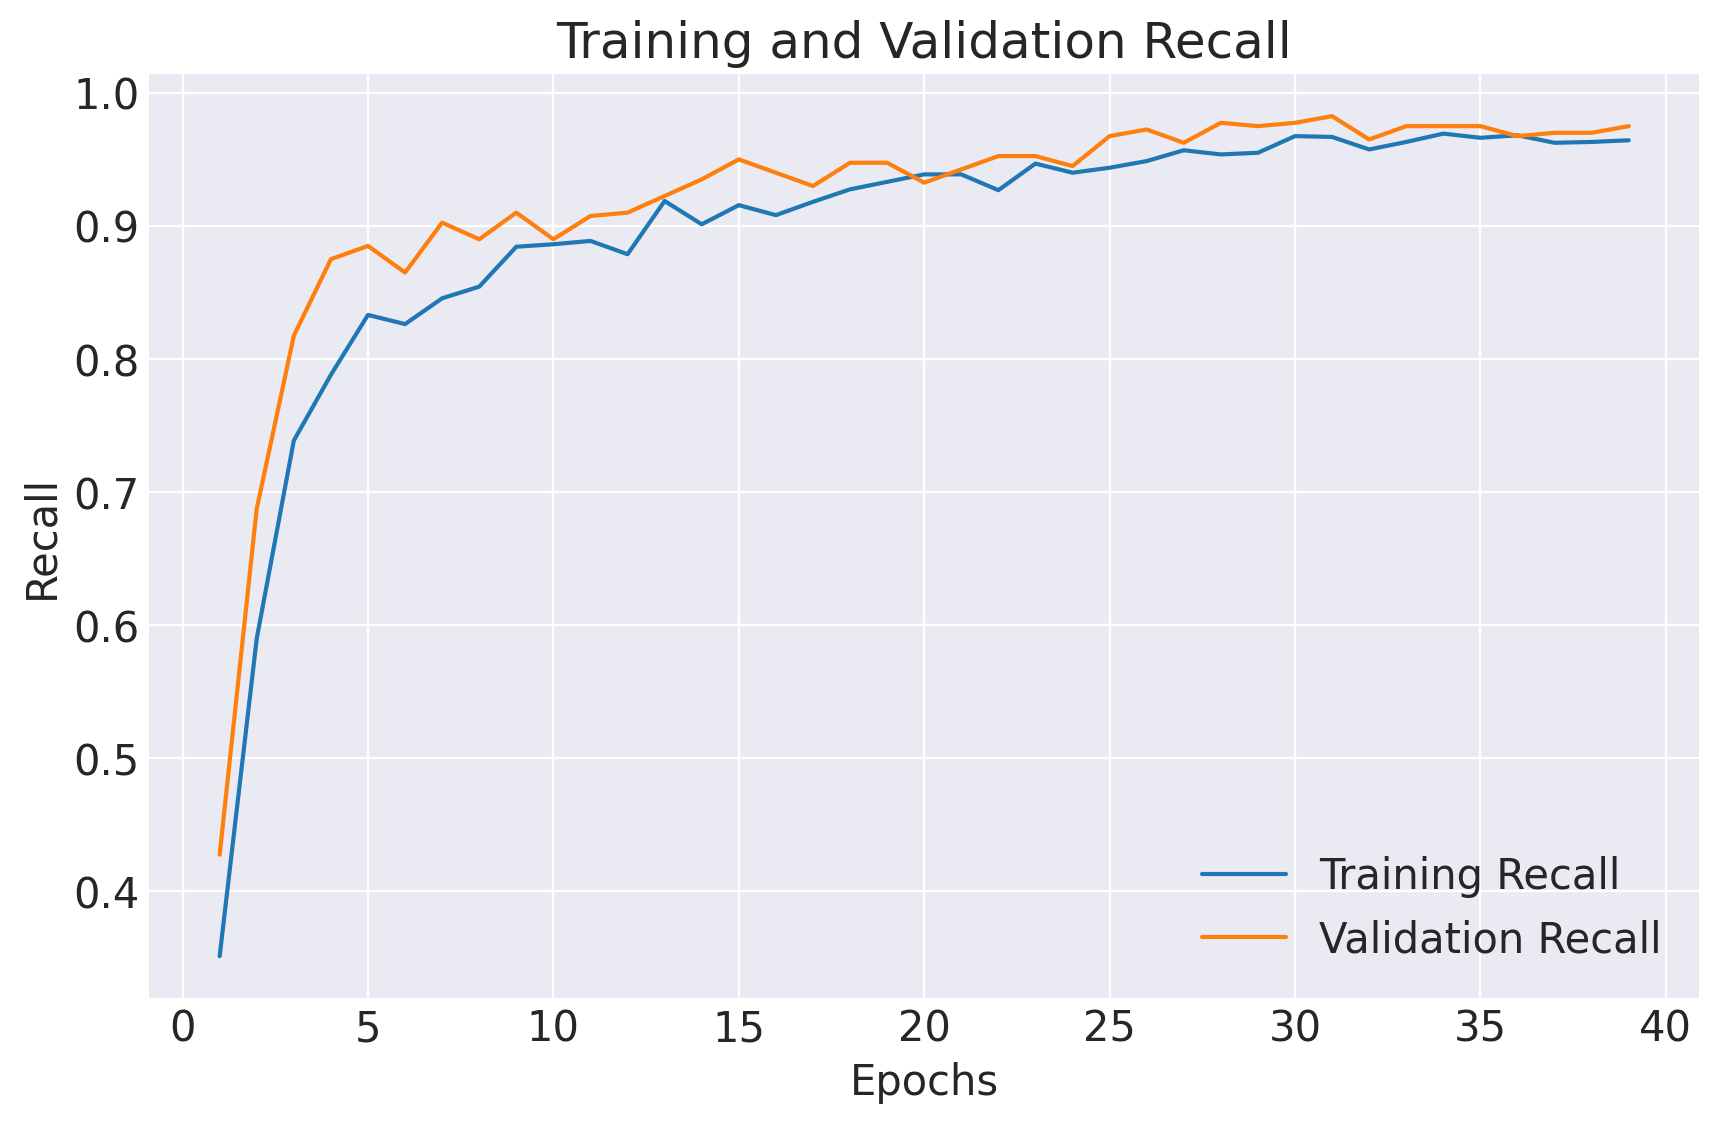

In [53]:
# Visualization of training and validation metrics
epochs_range = range(1, epochs + 1)

# Loss graph
plt.figure(figsize=(10, 6))
plt.plot(epochs_range, history['train_loss'], label='Training Loss')
plt.plot(epochs_range, history['valid_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('loss_plot.png')

# F1 Score graph
plt.figure(figsize=(10, 6))
plt.plot(epochs_range, history['train_f1_score'], label='Training F1 Score')
plt.plot(epochs_range, history['valid_f1_score'], label='Validation F1 Score')
plt.title('Training and Validation F1 Score')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()
plt.savefig('f1_score_plot.png')

# Accuracy graph
plt.figure(figsize=(10, 6))
plt.plot(epochs_range, history['train_accuracy'], label='Training Accuracy')
plt.plot(epochs_range, history['valid_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('accuracy_plot.png')

# Precision graph
plt.figure(figsize=(10, 6))
plt.plot(epochs_range, history['train_precision'], label='Training Precision')
plt.plot(epochs_range, history['valid_precision'], label='Validation Precision')
plt.title('Training and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.savefig('precision_plot.png')

# Recall graph
plt.figure(figsize=(10, 6))
plt.plot(epochs_range, history['train_recall'], label='Training Recall')
plt.plot(epochs_range, history['valid_recall'], label='Validation Recall')
plt.title('Training and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.savefig('recall_plot.png')

/home/elicer/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 50577 (\N{HANGUL SYLLABLE YANG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/elicer/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 54408 (\N{HANGUL SYLLABLE PUM}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/elicer/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/elicer/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 53356 (\N{HANGUL SYLLABLE KEU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/elicer/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 47000 (\N{HANGUL SYLLABLE RAE}) missing from font(s) DejaVu Sans.
 

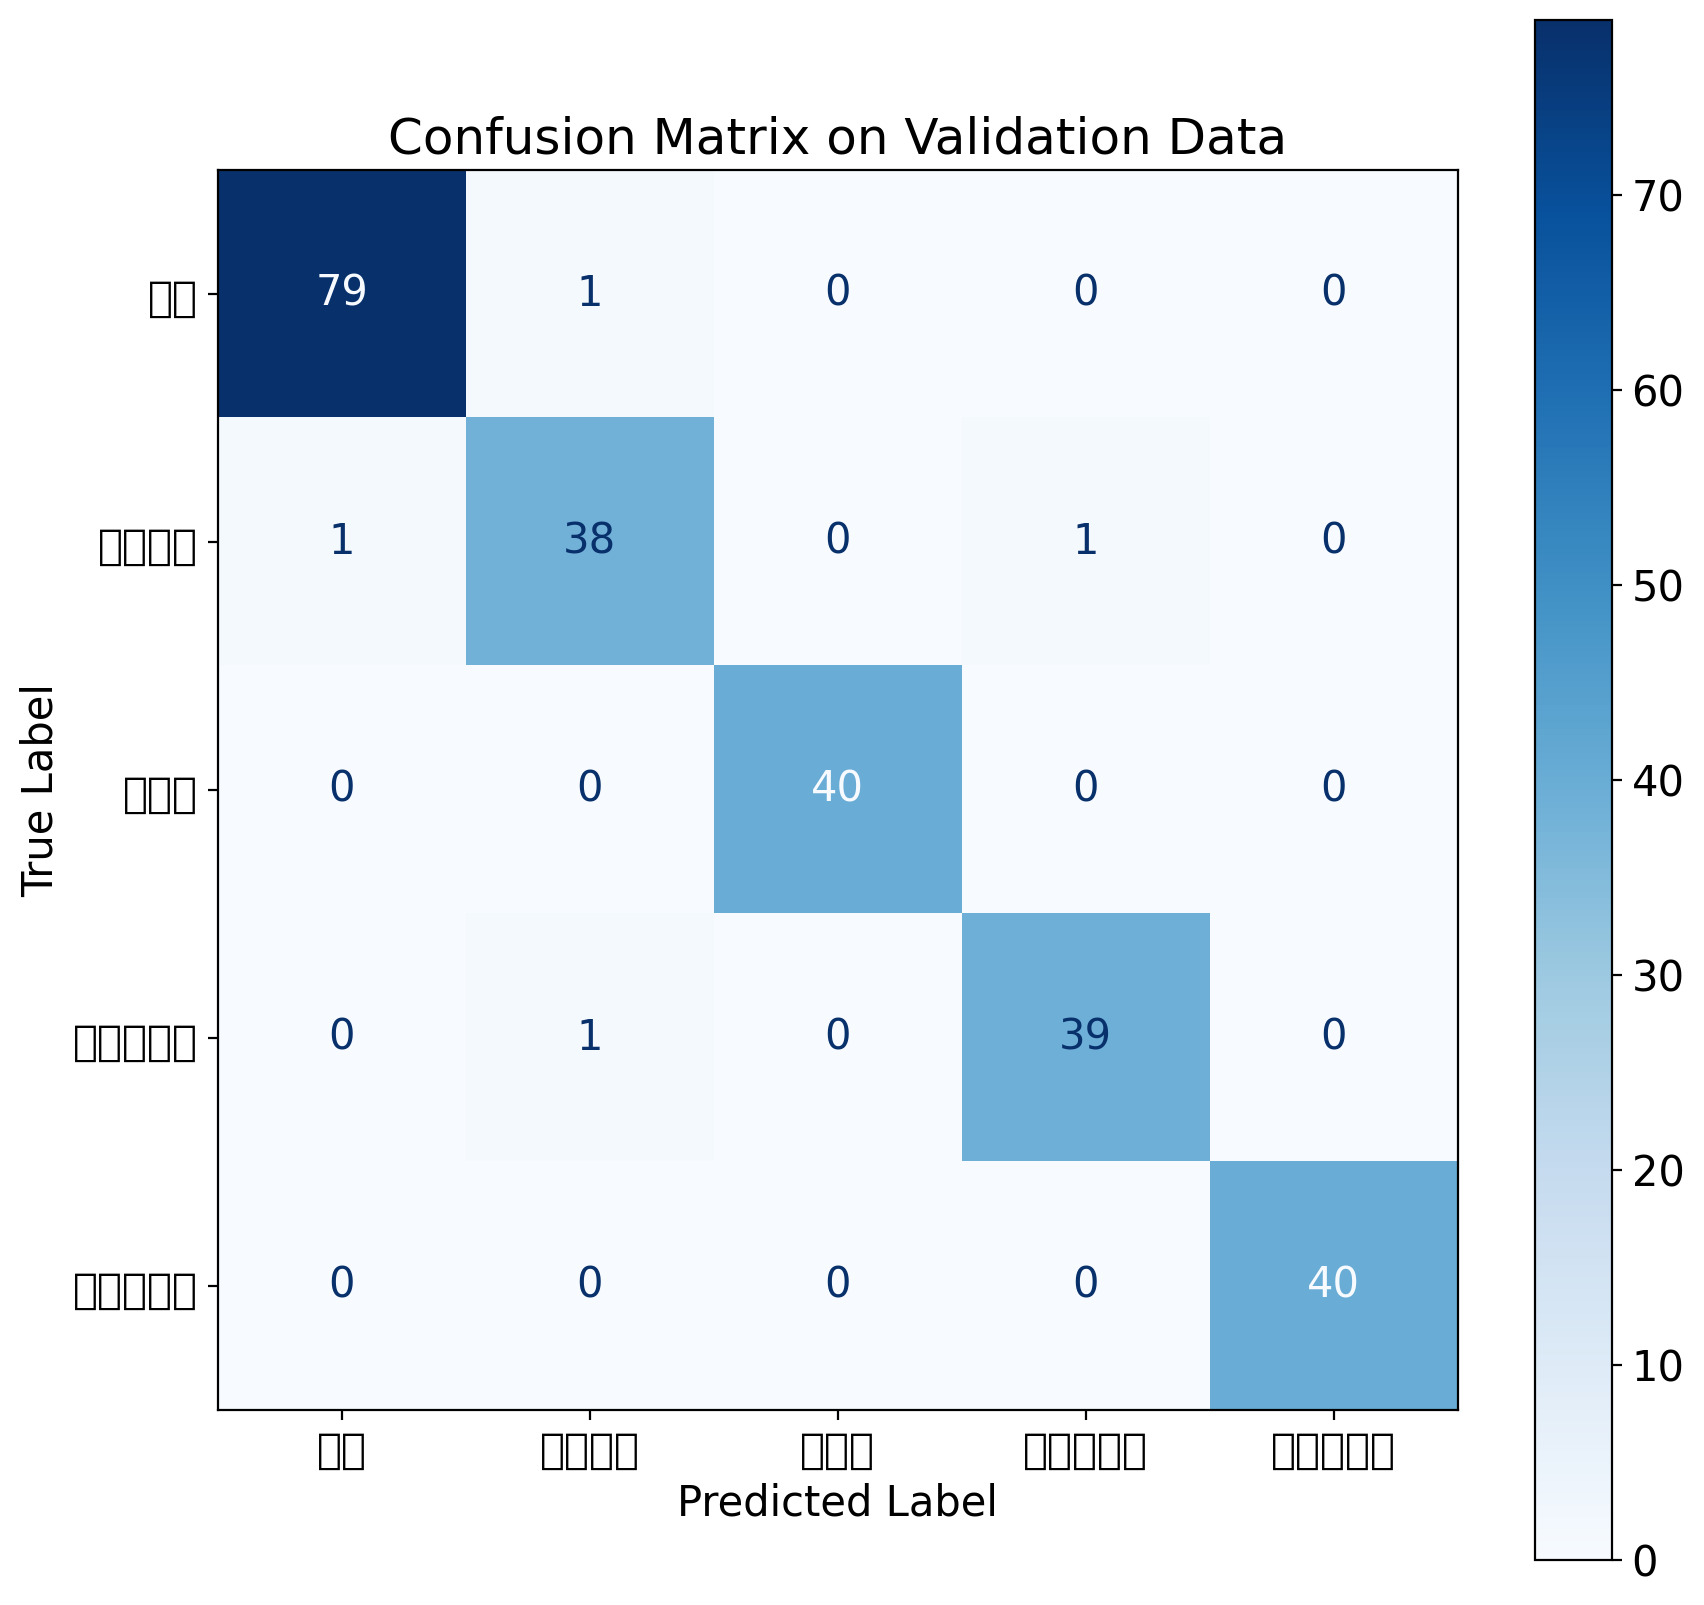

-------------------- Classification Report --------------------
              precision    recall  f1-score   support

          양품       0.99      0.99      0.99        80
        스크래치       0.95      0.95      0.95        40
         부풀음       1.00      1.00      1.00        40
       도막떨어짐       0.97      0.97      0.97        40
       이물질포함       1.00      1.00      1.00        40

    accuracy                           0.98       240
   macro avg       0.98      0.98      0.98       240
weighted avg       0.98      0.98      0.98       240

---------------------------------------------------------------


In [63]:
def evaluate_and_plot(model, loader_valid, device, class_names):
    """
    Validation 데이터셋에 대한 Confusion Matrix 및 Classification Report를 생성하고 시각화합니다.
    
    Args:
        model (torch.nn.Module): 훈련된 모델
        loader_valid (torch.utils.data.DataLoader): 검증 데이터 로더
        device (str): 모델이 위치한 장치 ('cpu' 또는 'cuda')
        class_names (list): 클래스 이름 목록 (예: ['cat', 'dog', 'bird'])
    """
    
    # 모델을 평가 모드로 전환
    model.eval()
    
    true_labels = []
    predictions = []
    
    # 그라디언트 계산 비활성화
    with torch.no_grad():
        for images, labels in loader_valid:
            images = images.to(device)
            
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            
            true_labels.extend(labels.cpu().numpy())
            predictions.extend(predicted.cpu().numpy())
    
    # == [ Confusion Matrix 시각화 ] =============================
    # Confusion Matrix 계산
    cm = confusion_matrix(true_labels, predictions)
    
    # Confusion Matrix 시각화
    fig, ax = plt.subplots(figsize=(10, 10))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues, ax=ax, values_format='d')
    
    ax.set_title('Confusion Matrix on Validation Data')
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    
    # 그래프를 화면에 표시
    plt.show()

    # == [ Classification Report 출력 ] ===========================
    # 각 클래스별 정밀도, 재현율, F1 점수를 포함하는 보고서 출력
    print("-------------------- Classification Report --------------------")
    print(classification_report(true_labels, predictions, target_names=class_names, zero_division=0))
    print("---------------------------------------------------------------")
    
    
# 클래스 이름을 정의 (실제 데이터셋의 클래스에 맞게 수정 필요)
class_names_list = ['양품', '스크래치', '부풀음', '도막떨어짐', '이물질포함']

# 함수 호출
evaluate_and_plot(
    model=model,
    loader_valid=loader_valid,
    device=device,
    class_names=class_names_list
)

## 제출 점수
1. Public Score : 0.8877167378911908

: Gray, (128, 128), validation_ratio=0.1, BS=32, RandomRotation(20)


2. Public Score : 0.9148165129790942

: RGB, (224, 224), validation_ratio=0.2, BS=4, RandomRotation(20)


3. Public Score : 0.889837765631273

: RGB, (384, 384), validation_ratio=0.2, BS=4, RandomRotation(20)

4. Public Score : 0.8215784967074498

: RGB, (224, 224), validation_ratio=0.2, BS=6, Val-F1, dropout, AdaptiveAvgPool2d(1, 1), RandomRotation(20)

5. Public Score : 0.851062761654215 (CNN Model 3)

: RGB, (224, 224), validation_ratio=0.2, BS=16, Val-F1, dropout, AvgPool2d(kernel_size=4), RandomRotation(30)

## 예측 및 결과 제출

In [38]:
SUBMIT_DIR = ROOT / "제출용 데이터"

filenames, labels = [], []
X_sub = []
for p in tqdm(SUBMIT_DIR.rglob("*")):
    if p.is_file() and p.suffix.lower() in IMG_EXTS:
#         im = Image.open(p).convert("L").resize(IMG_SIZE)
        im = Image.open(p).resize(IMG_SIZE)
        x = np.array(im, dtype=np.float32) / 255.0
        X_sub.append(x)
#         y_pred = clf.predict(x)
#         label_ko = le.inverse_transform(y_pred)[0]  # 한글 라벨 복원
        filenames.append(p.name)  # 인덱스는 파일명(문자열)
#         labels.append(label_ko)

0it [00:00, ?it/s]

In [39]:
len(filenames)

1000

In [40]:
# Dataset 객체 생성
dataset_test = ImageDataset(X=X_sub, transform=transform_test)

# DataLoader 객체 생성
loader_test = DataLoader(dataset=dataset_test, batch_size=batch_size, shuffle=False, worker_init_fn=seed_worker,
                         generator=g, num_workers=2)

### 추론

In [41]:
def predict(model, loader_test):
    model.eval()    # 모델을 평가 상태로 설정
    preds_list = [] # 예측값 저장용 리스트 초기화
    true_list = []  # 실제값 저장용 리스트 초기화

    with torch.no_grad(): # 기울기 계산 비활성
        for images in tqdm(loader_test):
            images = images.to(device)
            
            outputs = model(images)
            
            preds = torch.argmax(outputs.cpu(), dim=1).numpy() # 예측값

            preds_list.extend(preds)

    return preds_list

In [42]:
preds_list = predict(model=model, 
                      loader_test=loader_test)

  0%|          | 0/63 [00:00<?, ?it/s]

In [43]:
label_dict = {'양품': 0, '스크래치': 1, '부풀음': 2, '도막떨어짐':3, '이물질포함':4}
reverse_label_map = {v: k for k, v in label_dict.items()}
preds_labels = [reverse_label_map[pred] for pred in preds_list]
# preds_labels

In [44]:
# 제출을 위한 데이터프레임 만들기
df_submit = pd.DataFrame({"label": preds_labels}, index=filenames)
df_submit = df_submit.sort_index() 
df_submit.to_csv("./submission.csv", encoding="utf-8")  # 현재 작업 디렉토리에 저장

df_submit.head()

label
00001.jpg  도막떨어짐
00002.jpg   스크래치
00003.jpg   스크래치
00004.jpg   스크래치
00005.jpg     양품

### 예측값 분포 확인

/home/elicer/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/elicer/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 47561 (\N{HANGUL SYLLABLE MAG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/elicer/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 46504 (\N{HANGUL SYLLABLE DDEOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/elicer/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 50612 (\N{HANGUL SYLLABLE EO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/elicer/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 51664 (\N{HANGUL SYLLABLE JIM}) missing from font(s) DejaVu Sans.
  

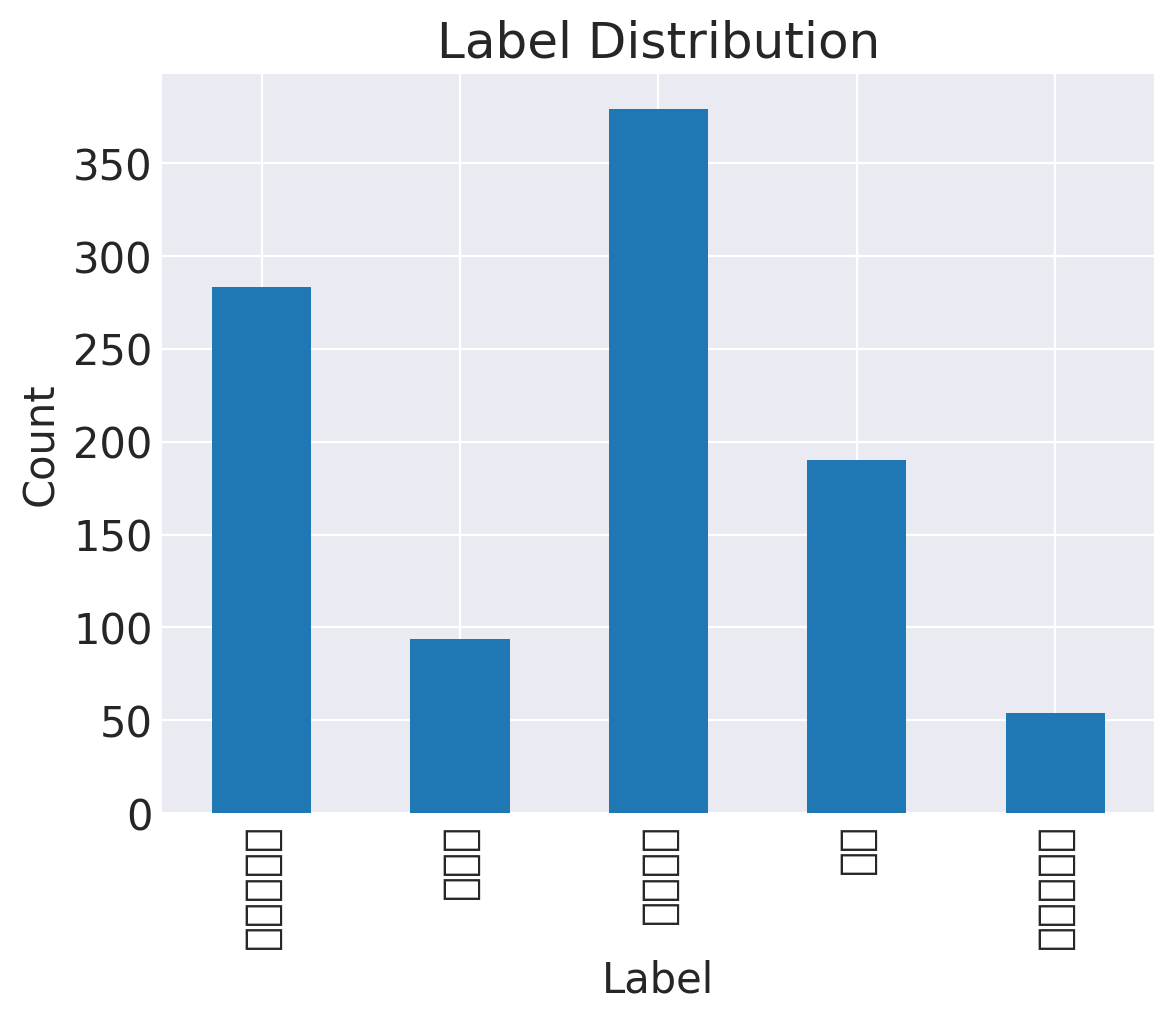

In [45]:
df_submit['label'].value_counts().sort_index().plot(kind='bar')

# 히스토그램 제목과 축 레이블 설정
plt.title('Label Distribution')
plt.xlabel('Label')
plt.ylabel('Count')

# 그래프 표시
plt.show()